# Import library

In [1]:
## 재현 가능하게하기 위하여 버전 출력
# 기본 패키지
import os
import time
import pandas as pd
import numpy as np

# 시각화 패키지
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='NanumBarunGothic') 
plt.style.use(['ggplot'])

# 경고 메시지 무시
import warnings
warnings.filterwarnings(action='ignore') 

# Clustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from mpl_toolkits.mplot3d import Axes3D


# EDA
from wordcloud import WordCloud
from collections import Counter

# 버전 확인
print('Pandas : %s'%(pd.__version__))
print('Numpy : %s'%(np.__version__))
print('seaborn : %s'%(sns.__version__))
print('matplotlib : %s'%(matplotlib.__version__))
!python --version

Pandas : 1.4.3
Numpy : 1.23.1
seaborn : 0.11.2
matplotlib : 3.5.3
Python 3.9.12


# Preprocessing

### Load Data

In [2]:
# Data Load
demo = pd.read_csv('../3. 우리 좀 롯데_데이터 및 모델 세이브 파일/LPOINT_BIG_COMP_01_DEMO.csv', low_memory=False)
pdde = pd.read_csv('../3. 우리 좀 롯데_데이터 및 모델 세이브 파일/LPOINT_BIG_COMP_02_PDDE.csv', low_memory=False)
cop = pd.read_csv('../3. 우리 좀 롯데_데이터 및 모델 세이브 파일/LPOINT_BIG_COMP_03_COP_U.csv', low_memory=False)
clac = pd.read_csv('../3. 우리 좀 롯데_데이터 및 모델 세이브 파일/LPOINT_BIG_COMP_04_PD_CLAC.csv', low_memory=False)
br = pd.read_csv('../3. 우리 좀 롯데_데이터 및 모델 세이브 파일/LPOINT_BIG_COMP_05_BR.csv', low_memory=False)
lpay = pd.read_csv('../3. 우리 좀 롯데_데이터 및 모델 세이브 파일/LPOINT_BIG_COMP_06_LPAY.csv', low_memory=False)

# Column명 변경
demo.columns = ['고객번호', '성별', '연령대', '거주지대분류코드']
pdde.columns = ['고객번호', '영수증번호', '채널구분', '제휴사', '점포코드', '상품코드', '구매일자', '구매시간', '구매금액', '구매수량']
cop.columns = ['고객번호', '영수증번호', '제휴사', '점포코드', '채널구분', '이용일자', '방문일자', '이용시간', '이용금액']
clac.columns = ['상품코드', '소분류명', '대분류명', '중분류명']
br.columns = ['점포코드', '제휴사', '점포대분류코드', '점포중분류코드']
lpay.columns = ['고객번호', '영수증번호', '제휴사', '채널구분', '이용일자', '이용시간', '이용금액']

### Data Preprocessing

- 가독성을 위하여 불필요한 데이터 확인과정 삭제

####  [2. pdde]: 상품 구매 정보

In [3]:
# 중복되는 행 제거 -> 데이터 추출시 고객, 상품 각각 추출하여 중복이 발생한 것으로 판단함
pdde.drop_duplicates(subset=None, keep='first', inplace=True, ignore_index=False)

# 결측치 치환 -> na값을 온라인으로 채워줌
pdde['점포코드'] = pdde['점포코드'].fillna('온라인')

#### [3. cop]: 제휴사 이용 정보

In [4]:
# 결측치 치환
cop['점포코드'] = cop['점포코드'].fillna('온라인')

# Data Merge

In [5]:
# 데이터를 통합하기 위하여 칼럼 통합
pdde['타입'] = 'Product'
cop['타입'] = 'Affiliate'
lpay['타입'] = 'Lpay'
pdde['방문일자'] = 0
lpay['방문일자'] = 0
cop['구매수량'] = 0
cop['상품코드'] = np.nan
lpay['점포코드'] = np.nan
lpay['상품코드'] = np.nan
lpay['구매수량'] = 0

In [6]:
# 칼럼명을 새롭게 동일하게 통일
cop.columns = ['고객번호', '영수증번호', '제휴사', '점포코드', '채널구분', '구매일자', '방문일자', '구매시간', '구매금액', '타입', '구매수량', '상품코드']
lpay.columns = ['고객번호', '영수증번호', '제휴사', '채널구분', '구매일자', '구매시간', '구매금액', '타입', '방문일자', '점포코드', '상품코드', '구매수량']

# 상품구매데이터를 기준으로 하여 열을 통일
cop = cop[['고객번호', '영수증번호', '채널구분', '제휴사', '점포코드', '상품코드', '구매일자', '방문일자', '구매시간', '구매금액', '구매수량', '타입']]
lpay = lpay[['고객번호', '영수증번호', '채널구분', '제휴사', '점포코드', '상품코드', '구매일자', '방문일자', '구매시간', '구매금액', '구매수량', '타입']]

# 데이터 타입 변경
lpay['영수증번호'] = lpay['영수증번호'].astype('object')
lpay['점포코드'] = lpay['점포코드'].astype('object')
cop['상품코드'] = cop['상품코드'].astype('object')
lpay['상품코드'] = lpay['상품코드'].astype('object')
pdde['구매금액'] = pdde['구매금액'].astype('int')
pdde['방문일자'] = pdde['방문일자'].astype('int64')
lpay['방문일자'] = lpay['방문일자'].astype('int64')

In [7]:
# 데이터 concat
df = pd.concat([pdde,cop,lpay])
# 고객 정보 테이블 통합
df = pd.merge(df, demo, on = ['고객번호'], how = 'left')
# 상품 분류 테이블 통합
df = pd.merge(df, br, on = ['점포코드','제휴사'], how = 'left')
# 점포 정보 테이블 통합
df = pd.merge(df, clac, on = ['상품코드'], how = 'left')

In [8]:
# 결측치 확인 -> 데이터를 합치면서 생기는 결측치만 존재
df.isnull().sum()

고객번호             0
영수증번호            0
채널구분             0
제휴사              0
점포코드        353184
상품코드        601488
구매일자             0
구매시간             0
구매금액             0
구매수량             0
타입               0
방문일자             0
성별               0
연령대              0
거주지대분류코드         0
점포대분류코드     729023
점포중분류코드     729023
소분류명        601488
대분류명        601488
중분류명        601488
dtype: int64

## Train Test Split

In [9]:
# 날짜로 변경
df['날짜'] = df['구매일자'].astype(str)
df['날짜'] = pd.to_datetime(df['날짜'])
# 각 거래일간의 차이를 구함
df = df.sort_values(by=['날짜'], ascending=[True])
df['diff'] = df.groupby('고객번호')['날짜'].diff().fillna('0').astype(str)
df['diff'] = df['diff'].apply(lambda x: int(x.split()[0]))
# 데이터를 거래횟수별로 나누기 위한 작업
trans = df.groupby('고객번호')['영수증번호'].apply(set).reset_index()
trans['거래횟수'] = trans['영수증번호'].apply(lambda x:len(list(x)))
# 뉴비와 올드비를 구분해줌
oldbie = trans[trans['거래횟수']>3]['고객번호'].tolist()
newbie = trans[trans['거래횟수']<=3]['고객번호'].tolist()

# 데이터 분리
df_old = df[df['고객번호'].isin(oldbie)]
df_new = df[df['고객번호'].isin(newbie)]

# RFM

In [10]:
customer_id = df_old.groupby('고객번호')[['구매일자']].max().index.tolist()
recency = df_old.groupby('고객번호')[['구매일자']].max()['구매일자'].tolist()
freq = df_old.groupby('고객번호')['영수증번호'].apply(set).reset_index()
frequency = freq['영수증번호'].apply(lambda x:len(list(x)))
monetary = df_old.groupby('고객번호')[['구매금액']].sum()['구매금액'].tolist()

df_rfm = pd.DataFrame({'Customer_ID': customer_id, 'Recency': recency, 'Frequency': frequency, 'Monetary': monetary})

In [11]:
df_rfm['Recency'] = df_rfm['Recency'].astype(str)
df_rfm['Recency'] = pd.to_datetime(df_rfm['Recency'])
df_rfm['Recency'] = df_rfm['Recency'] - pd.to_datetime('20210101')

df_rfm['Recency'] = df_rfm['Recency'].dt.days # days로
df_rfm

,Customer_ID,Recency,Frequency,Monetary
0,M000034966,356,13,616240
1,M000136117,363,89,28697031
2,M000201112,331,5,51420
3,M000225114,364,88,2084270
4,M000261625,337,49,6072050
...,...,...,...,...
26207,M999673157,351,17,2851370
26208,M999770689,364,216,2078770
26209,M999849895,334,35,1095312
26210,M999926092,335,7,129500


# Data Clustering

- k-means를 위한 Scaling

In [12]:
scaler = StandardScaler()
scaler.fit(df_rfm.iloc[:,1:])

StandardScaler()

In [13]:
rfm_scaled = scaler.transform(df_rfm.iloc[:,1:]) 

rfm_scaled_df = pd.DataFrame(rfm_scaled, columns = df_rfm.iloc[:,1:].columns) 
rfm_scaled_df.insert(0, 'Customer_ID', df_rfm['Customer_ID'])
rfm_scaled_df

,Customer_ID,Recency,Frequency,Monetary
0,M000034966,0.388787,-0.682454,-0.292294
1,M000136117,0.549046,0.211318,1.677066
2,M000201112,-0.183566,-0.776535,-0.331906
3,M000225114,0.571940,0.199558,-0.189339
4,M000261625,-0.046201,-0.259088,0.090332
...,...,...,...,...
26207,M999673157,0.274316,-0.635413,-0.135540
26208,M999770689,0.571940,1.704857,-0.189724
26209,M999849895,-0.114884,-0.423730,-0.258696
26210,M999926092,-0.091990,-0.753015,-0.326430


- Clustering

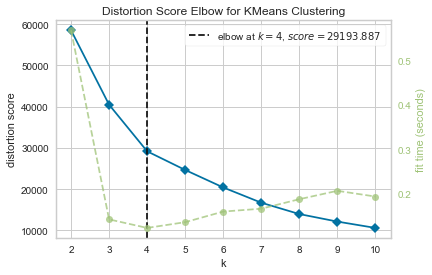

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [14]:
kmeans = KMeans(random_state=np.random.RandomState(seed=42))

elb_visualizer = KElbowVisualizer(kmeans, k=(2,11))
elb_visualizer.fit(rfm_scaled_df.iloc[:,1:])
elb_visualizer.show()

- 실루엣 계수 확인

In [15]:
# 실루엣 계수가 0.5가 넘기 때문에 군집화가 잘 진행된 것을 볼 수 있음
model_4clust = KMeans(n_clusters = 4, random_state=np.random.RandomState(seed=42))
model_4clust.fit(rfm_scaled_df.iloc[:,1:])
cluster = model_4clust.predict(rfm_scaled_df.iloc[:,1:])
score = silhouette_score(rfm_scaled_df.iloc[:,1:], cluster);score

0.5878745632403845

- 군집 라벨링

In [16]:
rfm_scaled_df['labels'] = cluster
rfm_df = rfm_scaled_df[['Customer_ID', 'labels']]
rfm_df.columns = ['고객번호', 'labels']
rfm_df.head(3)

,고객번호,labels
0,M000034966,0
1,M000136117,2
2,M000201112,0


- data merge

In [17]:
df_old = pd.merge(df_old, rfm_df, on = ['고객번호'], how = 'left')
df_old.head(3)

,고객번호,영수증번호,채널구분,제휴사,점포코드,상품코드,구매일자,구매시간,구매금액,구매수량,...,연령대,거주지대분류코드,점포대분류코드,점포중분류코드,소분류명,대분류명,중분류명,날짜,diff,labels
0,M495972460,20122713C012328716,2,C01,C010004,NaN,20201227,13,26000,0,...,40대,Z10,Z17,Z17011,NaN,NaN,NaN,2020-12-27,0,0
1,M039320884,20122911C011862577,2,C01,C010117,NaN,20201229,11,6500,0,...,40대,Z06,Z06,Z06013,NaN,NaN,NaN,2020-12-29,0,2
2,M192531170,20122900C013317930,2,C01,C010026,NaN,20201229,0,10000,0,...,40대,Z10,Z10,Z10011,NaN,NaN,NaN,2020-12-29,0,0


### 군집별 특징 시각화

- 전체 군집에 대해
    - 연령대 비교 -> 별다른 특징 없음
    - 성별 비교 -> 별다른 특징 없음
    - 거주지 비교 -> 별다른 특징 없음

In [18]:
# 사용자 운영체제 확인
import platform
platform.system()

# 운영체제별 한글 폰트 설정
if platform.system() == 'Darwin': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')

plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정


# 글씨 선명하게 출력하는 설정
%config InlineBackend.figure_format = 'retina'

In [19]:
rfm_df.groupby('labels').count()['고객번호']

labels
0    20339
1     2258
2     3552
3       63
Name: 고객번호, dtype: int64

In [20]:
# 이전 시각화와 라벨을 맞춰줌
customer_0 = rfm_df[rfm_df['labels'] == 1]['고객번호']
customer_1 = rfm_df[rfm_df['labels'] == 0]['고객번호']
customer_2 = rfm_df[rfm_df['labels'] == 3]['고객번호']
customer_3 = rfm_df[rfm_df['labels'] == 2]['고객번호']

#### 각 군집별 평균 RFM을 시각화함

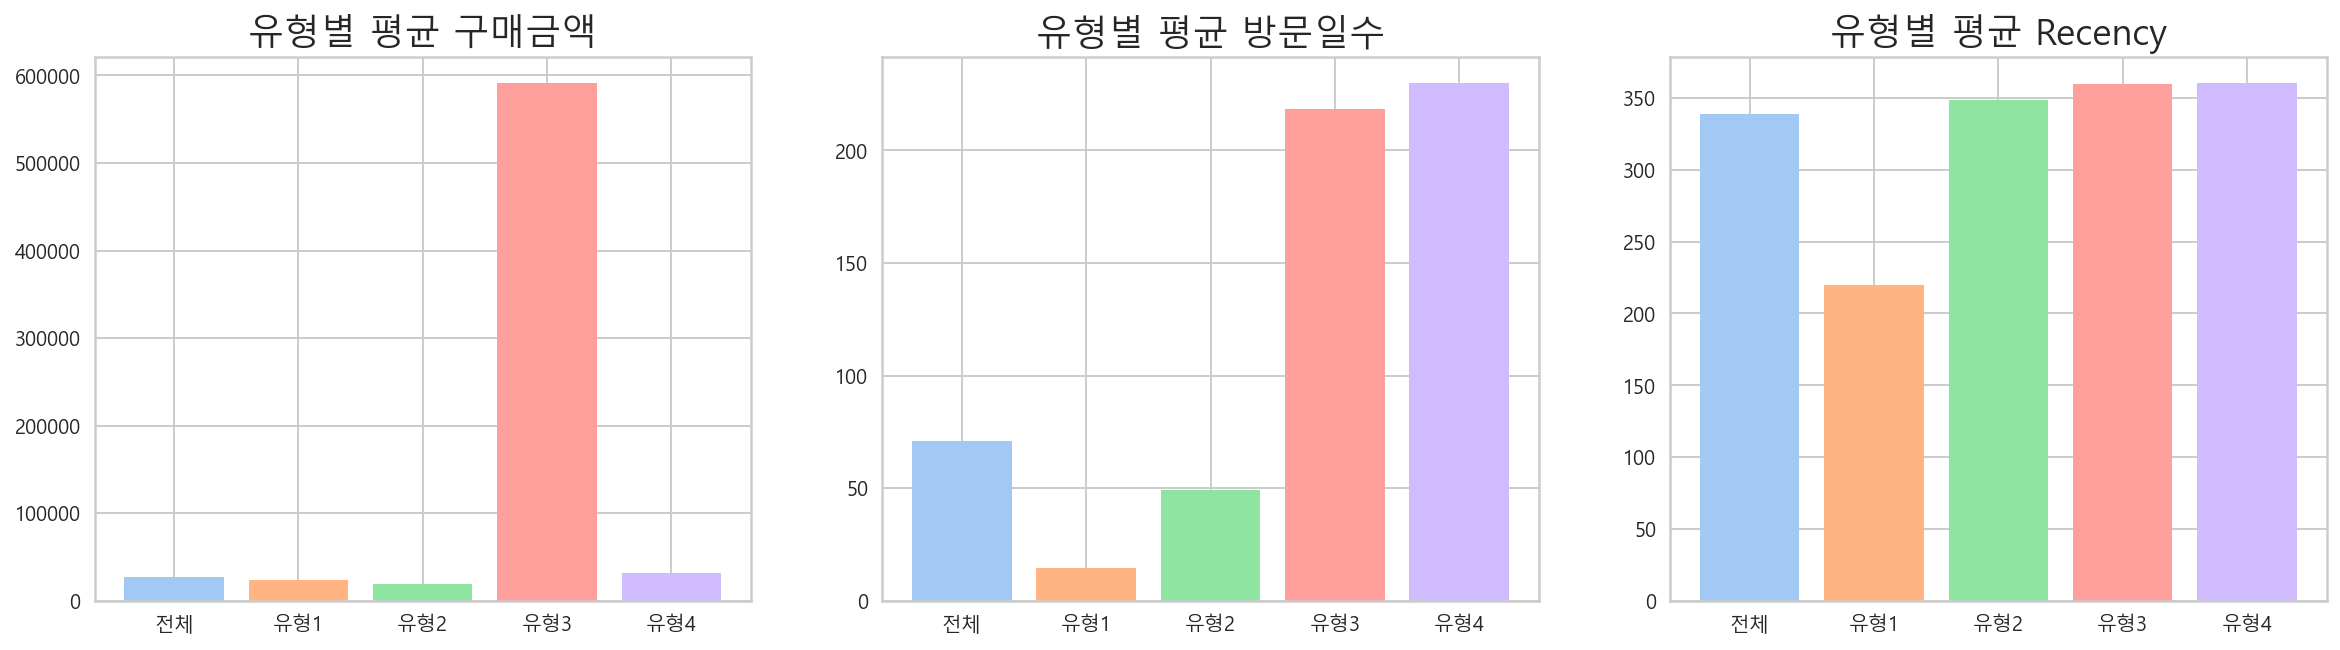

In [21]:
colors = sns.color_palette('pastel',5) # 색상 지정

plt.figure(figsize=(20,5))
# 구매금액
plt.subplot(1, 3, 1)
plt.bar(['전체', '유형1', '유형2', '유형3', '유형4'], [df['구매금액'].mean(), df.loc[df['고객번호'].isin(customer_0)]['구매금액'].mean(), df.loc[df['고객번호'].isin(customer_1)]['구매금액'].mean(),df.loc[df['고객번호'].isin(customer_2)]['구매금액'].mean(), 
                                             df.loc[df['고객번호'].isin(customer_3)]['구매금액'].mean()],color = colors)
plt.title('유형별 평균 구매금액', fontsize=18)
# 방문일수
plt.subplot(1, 3, 2)
plt.bar(['전체', '유형1', '유형2', '유형3', '유형4'],[df_rfm['Frequency'].mean(),df_rfm.loc[df_rfm['Customer_ID'].isin(customer_0)]['Frequency'].mean(),df_rfm.loc[df_rfm['Customer_ID'].isin(customer_1)]['Frequency'].mean(),
        df_rfm.loc[df_rfm['Customer_ID'].isin(customer_2)]['Frequency'].mean(), df_rfm.loc[df_rfm['Customer_ID'].isin(customer_3)]['Frequency'].mean()],color = colors)
plt.title('유형별 평균 방문일수', fontsize=18)

# Recency
plt.subplot(1, 3, 3)
plt.bar(['전체', '유형1', '유형2', '유형3', '유형4'], [df_rfm['Recency'].mean(),df_rfm.loc[df_rfm['Customer_ID'].isin(customer_0)]['Recency'].mean(),
        df_rfm.loc[df_rfm['Customer_ID'].isin(customer_1)]['Recency'].mean(),df_rfm.loc[df_rfm['Customer_ID'].isin(customer_2)]['Recency'].mean(), 
                                             df_rfm.loc[df_rfm['Customer_ID'].isin(customer_3)]['Recency'].mean()],color = colors)
plt.title('유형별 평균 Recency', fontsize=18)
plt.show()

*-유형1, 그냥 한번 들러봄*
- 유형1은 전체 데이터와 비교하였을 때, 평균 구매금액, 평균 방문일수, 평균 Recency모두가 낮은 것을 확인할 수 있다
    - 즉, 4개의 유형 중 가장 충성도가 낮은 고객이라고 할 수 있다.
    - 이후 마케팅 전략에서 해당 유형의 충성도를 높일 수 있는 전략을 짜면 좋을듯함

*-유형2, 다수*
- 유형2는 네개의 유형 중, 가장 속한 고객의 수가 높은 유형이다. 해당 그래프에서는 두드러지는 특징을 확인할 수 없다.

*-유형3, 충성고객VIP*
- 유형3은 네개의 유형 중, 속한 고객의 수가 가장 적은 유형이다. 해당 유형은 평균 구매금액이 다른 유형들에 비해 눈에 띄게 높음을 알 수 있다. 
- 또한, 평균 방문일수와 평균 Recency 또한 높음을 알 수 있다.
    - 쉽게 말해 본 회사의 VIP라고 볼 수 있다.
    - 이후 마케팅 전략에서 해당 유형은 이탈을 방지할 수 있는 전략을 수립하면 좋을듯함

*-유형4, 관심 고객*
- 유형4는 전체와 비교하였을 때, 평균 구매금액은 낮으나 평균 방문일수와 Recency점수가 높음을 알 수 있다.
    - 즉, 구매력은 높지 않으나 본회사에 지속적인 관심을 가지고 있음을 알 수 있다.
    - 이후 마케팅 전략에서 구매 금액을 지속적으로 향상시킬 수 있는 방안을 모색하면 좋을듯함

#### 유형별 연령대 분포

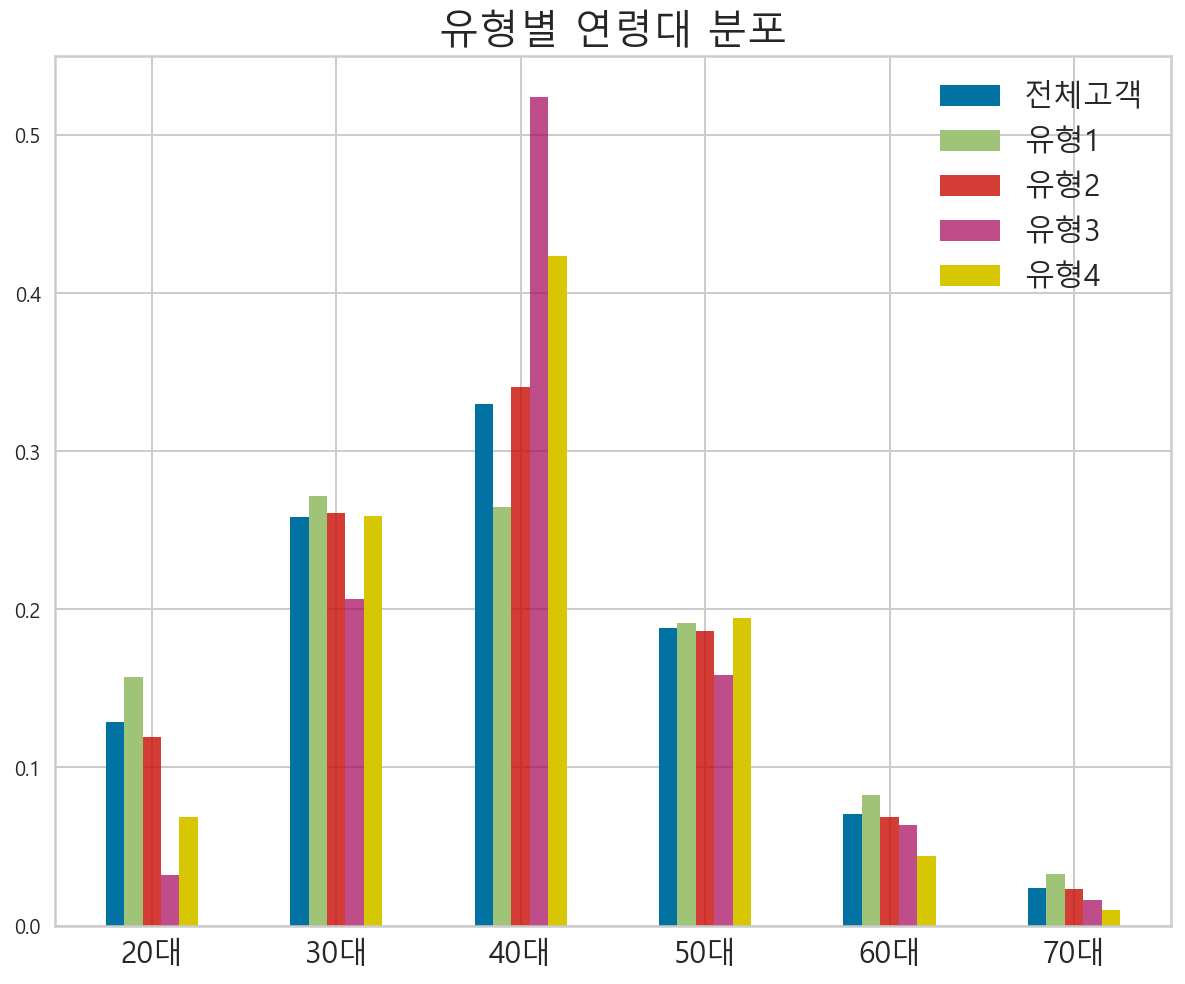

In [22]:
x = np.arange(6)

plt.figure(figsize=(10, 8))
# 전체
plt.bar(x-0.2, demo.groupby('연령대')['고객번호'].count().reset_index()['고객번호'] / demo.groupby('연령대')['고객번호'].count().sum(), 0.1, label='전체고객')
# 유형1
plt.bar(x-0.1,demo[demo['고객번호'].isin(customer_0)].groupby('연령대')['고객번호'].count().reset_index()['고객번호'] / \
               demo[demo['고객번호'].isin(customer_0)].groupby('연령대')['고객번호'].count().sum(), 0.1, label='유형1')
# 유형2
plt.bar(x,demo[demo['고객번호'].isin(customer_1)].groupby('연령대')['고객번호'].count().reset_index()['고객번호'] / \
               demo[demo['고객번호'].isin(customer_1)].groupby('연령대')['고객번호'].count().sum(), 0.1, label='유형2', alpha=0.8)
# 유형3
plt.bar(x+0.1,demo[demo['고객번호'].isin(customer_2)].groupby('연령대')['고객번호'].count().reset_index()['고객번호'] / \
               demo[demo['고객번호'].isin(customer_2)].groupby('연령대')['고객번호'].count().sum(), 0.1, label='유형3', alpha=0.7)

# 유형4
plt.bar(x+0.2,demo[demo['고객번호'].isin(customer_3)].groupby('연령대')['고객번호'].count().reset_index()['고객번호'] / \
               demo[demo['고객번호'].isin(customer_3)].groupby('연령대')['고객번호'].count().sum(), 0.1, label='유형4')

plt.xticks(x, ['20대', '30대', '40대', '50대', '60대', '70대'], fontsize = 15)
plt.legend(fontsize = 15)
plt.title('유형별 연령대 분포', fontsize=20)
plt.show()

#### 유형별 거주지 비교

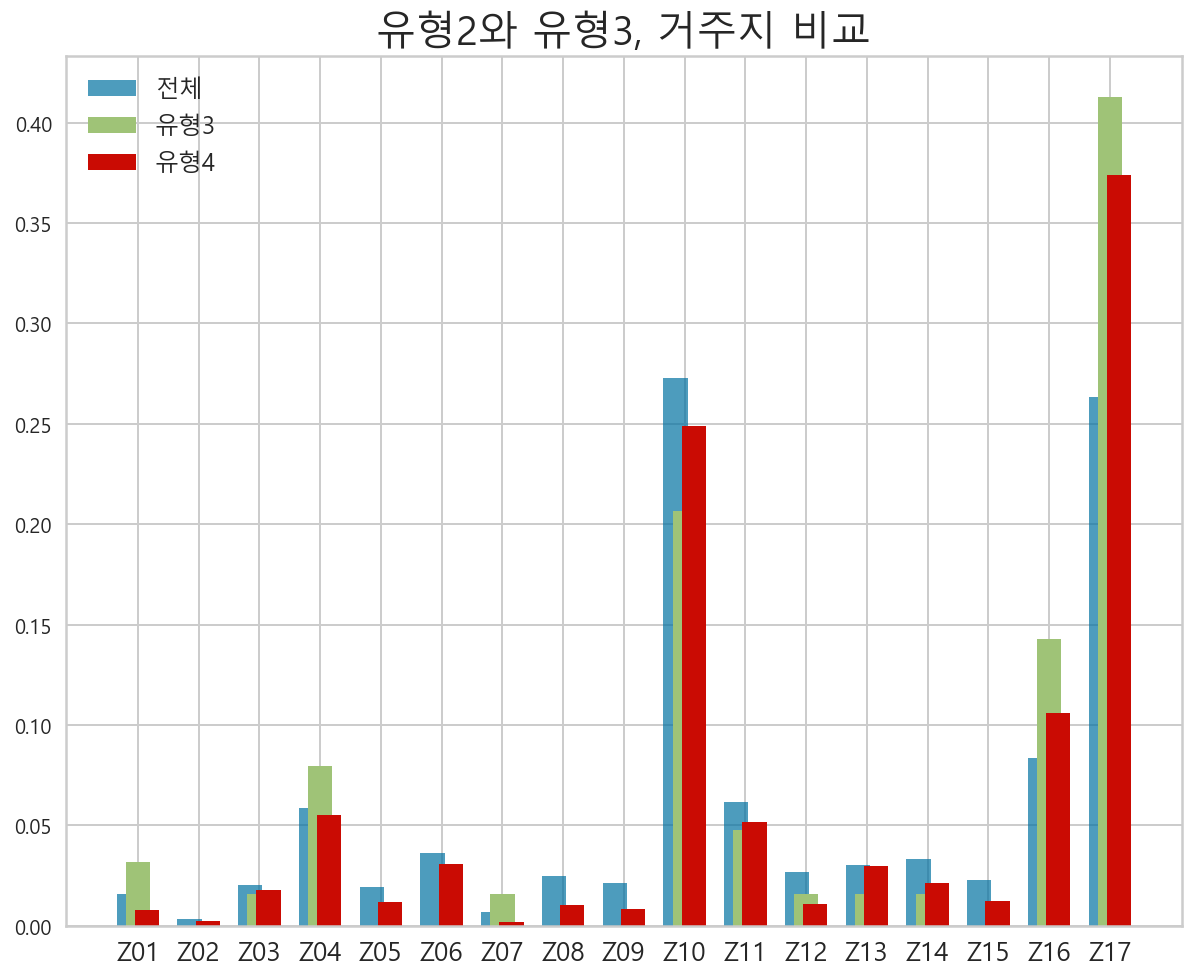

In [23]:
cust_2_resi = pd.concat([demo[demo['고객번호'].isin(customer_2)].groupby('거주지대분류코드')['고객번호'].count().reset_index(), 
           pd.DataFrame([['Z02', 0], ['Z05', 0], ['Z06', 0], ['Z08', 0], ['Z09', 0], ['Z15', 0]], 
           columns=['거주지대분류코드', '고객번호'])]).sort_values(by='거주지대분류코드').reset_index(drop=True)


plt.figure(figsize=(10, 8))
x = np.arange(len(cust_2_resi['거주지대분류코드']))
plt.bar(x-0.15, demo.groupby('거주지대분류코드')['고객번호'].count() /\
                demo.groupby('거주지대분류코드')['고객번호'].count().sum(), 0.4, label='전체', alpha=0.7)
plt.bar(x, cust_2_resi['고객번호'] / cust_2_resi['고객번호'].sum(), 0.4, label='유형3')
plt.bar(x+0.15, demo[demo['고객번호'].isin(customer_3)].groupby('거주지대분류코드')['고객번호'].count() /\
                demo[demo['고객번호'].isin(customer_3)].groupby('거주지대분류코드')['고객번호'].count().sum(), 0.4, label='유형4')

plt.xticks(x, cust_2_resi['거주지대분류코드'],fontsize = 13)
plt.legend(fontsize = 12)
plt.title('유형2와 유형3, 거주지 비교', fontsize = 20)
plt.show()

#### 유형별 주구매시간 파악

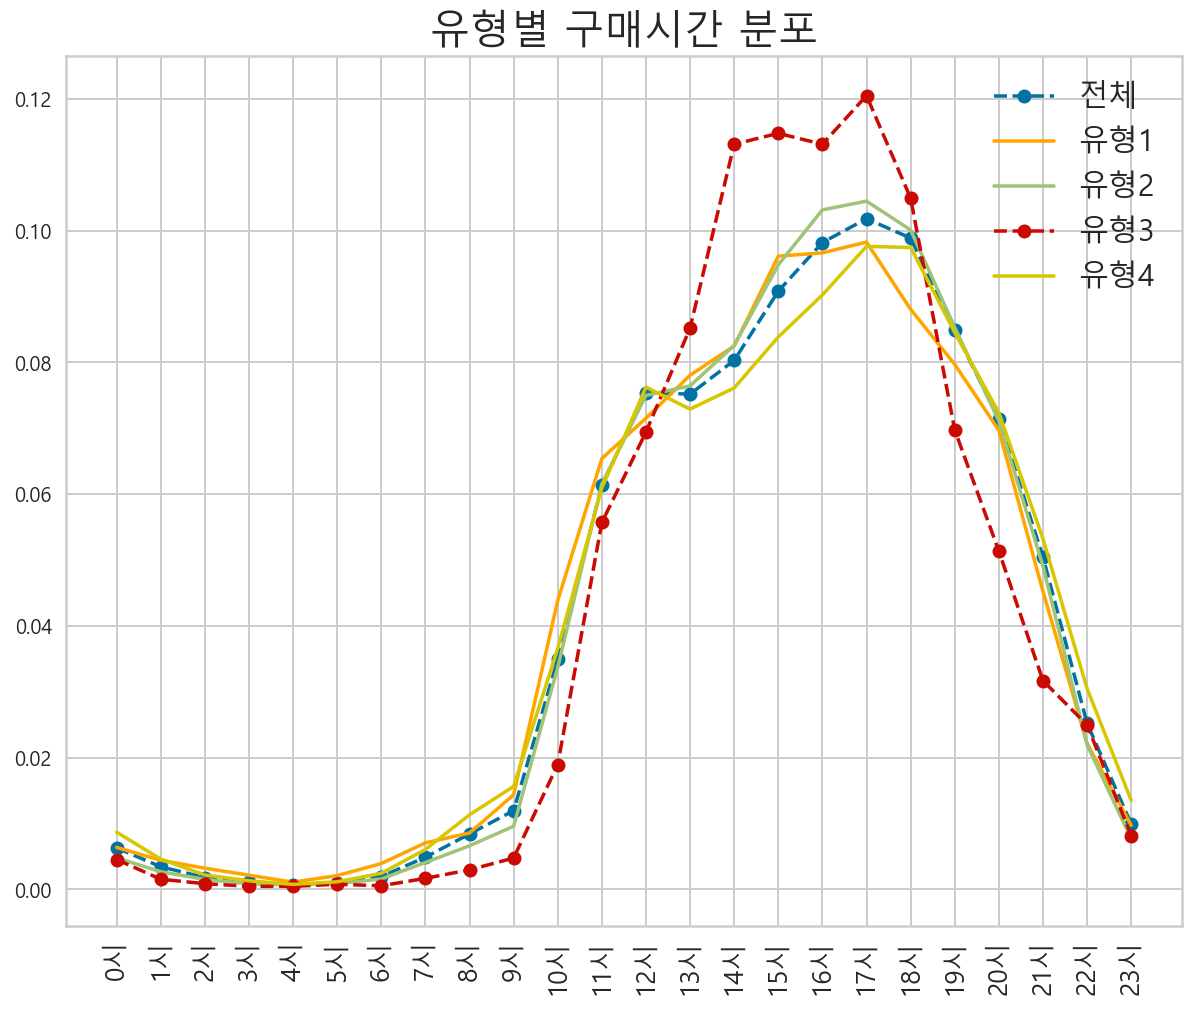

In [24]:
plt.figure(figsize=(10, 8))
x = np.arange(len(df['구매시간'].unique()))
plt.plot(df.groupby('구매시간')['고객번호'].count().reset_index()['구매시간'], 
         df.groupby('구매시간')['고객번호'].count().reset_index()['고객번호'] /\
         df.groupby('구매시간')['고객번호'].count().reset_index()['고객번호'].sum(), label='전체',linestyle='--',marker='o', c='b')
plt.plot(df[df['고객번호'].isin(customer_0)].groupby('구매시간')['고객번호'].count().reset_index()['구매시간'], 
         df[df['고객번호'].isin(customer_0)].groupby('구매시간')['고객번호'].count().reset_index()['고객번호'] /\
         df[df['고객번호'].isin(customer_0)].groupby('구매시간')['고객번호'].count().reset_index()['고객번호'].sum(), label='유형1', c='orange')
plt.plot(df[df['고객번호'].isin(customer_1)].groupby('구매시간')['고객번호'].count().reset_index()['구매시간'], 
         df[df['고객번호'].isin(customer_1)].groupby('구매시간')['고객번호'].count().reset_index()['고객번호'] /\
         df[df['고객번호'].isin(customer_1)].groupby('구매시간')['고객번호'].count().reset_index()['고객번호'].sum(), label='유형2',c='g')
plt.plot(df[df['고객번호'].isin(customer_2)].groupby('구매시간')['고객번호'].count().reset_index()['구매시간'], 
         df[df['고객번호'].isin(customer_2)].groupby('구매시간')['고객번호'].count().reset_index()['고객번호'] /\
         df[df['고객번호'].isin(customer_2)].groupby('구매시간')['고객번호'].count().reset_index()['고객번호'].sum(), label='유형3',linestyle='--',marker='o', c='r')
plt.plot(df[df['고객번호'].isin(customer_3)].groupby('구매시간')['고객번호'].count().reset_index()['구매시간'], 
         df[df['고객번호'].isin(customer_3)].groupby('구매시간')['고객번호'].count().reset_index()['고객번호'] /\
         df[df['고객번호'].isin(customer_3)].groupby('구매시간')['고객번호'].count().reset_index()['고객번호'].sum(), label='유형4', c='y')
plt.xticks(x, [f'{i}시' for i in range(24)],fontsize = 13)
plt.xticks(rotation=90) #x축 값 세로로 변경
plt.title('유형별 구매시간 분포', fontsize = 20)
plt.legend(fontsize = 15)
plt.show()

#### Lpay

- Lpay이용자의 비율을 확인

In [25]:
unuse_Lpay = demo[demo['고객번호'].isin(set(df[df['타입'] == 'Lpay']['고객번호'])) == False]['고객번호']
useLpay = demo[demo['고객번호'].isin(set(df[df['타입'] == 'Lpay']['고객번호']))]['고객번호']

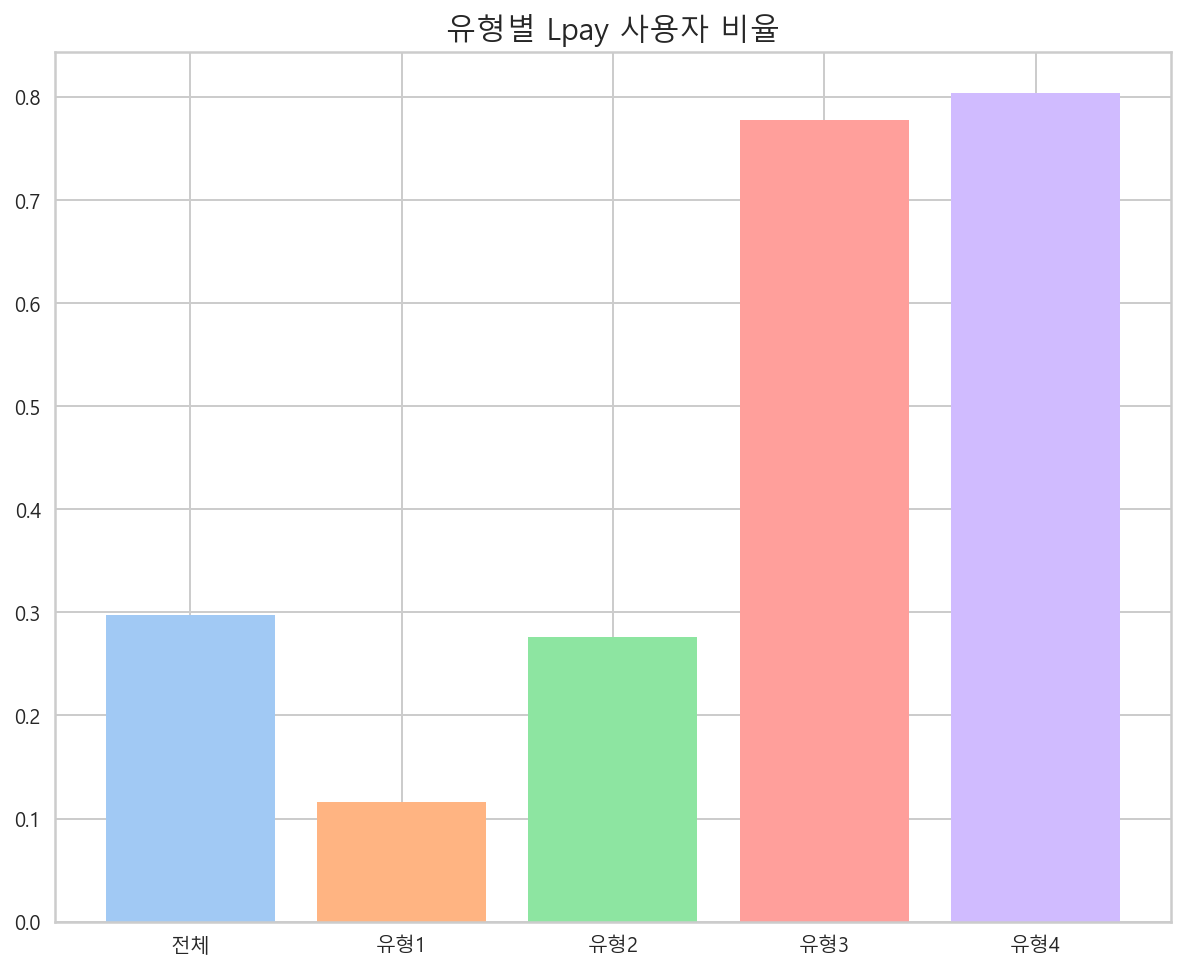

In [26]:
# Lpay이용자의 비율을 확인해봄
## 전체
lpay_ratio = [(len(useLpay) / len(demo)),  (len(customer_0[customer_0.isin(useLpay)]) / len(customer_0)), (len(customer_1[customer_1.isin(useLpay)]) / len(customer_1)),
            (len(customer_2[customer_2.isin(useLpay)]) / len(customer_2)), (len(customer_3[customer_3.isin(useLpay)]) / len(customer_3))]

colors = sns.color_palette('pastel',5)
plt.figure(figsize=(10, 8))
plt.bar(['전체', '유형1', '유형2', '유형3', '유형4'], lpay_ratio, color = colors)
plt.title('유형별 Lpay 사용자 비율', fontsize=15)
plt.show()

    - 전체와 비교해 보았을 때, 유형1의 경우 Lpay이용자의 수가 매우 적고, 유형3,4의 경우 이용률이 높음을 알 수 있음. 

- Lpay 이용자와 미이용자의 평균 구매금액 비교

In [27]:
lpay_x = [
          df[df['고객번호'].isin(unuse_Lpay)]['구매금액'].mean(),
          df[df['고객번호'].isin(customer_0[customer_0.isin(useLpay)==False])]['구매금액'].mean(),
          df[df['고객번호'].isin(customer_1[customer_1.isin(useLpay)==False])]['구매금액'].mean(), 
          df[df['고객번호'].isin(customer_2[customer_2.isin(useLpay)==False])]['구매금액'].mean(),
          df[df['고객번호'].isin(customer_3[customer_3.isin(useLpay)==False])]['구매금액'].mean()
         ]
lpay_o = [df[df['고객번호'].isin(useLpay)]['구매금액'].mean(), df[df['고객번호'].isin(customer_0[customer_0.isin(useLpay)])]['구매금액'].mean(),
          df[df['고객번호'].isin(customer_1[customer_1.isin(useLpay)])]['구매금액'].mean(), df[df['고객번호'].isin(customer_2[customer_2.isin(useLpay)])]['구매금액'].mean(),
          df[df['고객번호'].isin(customer_3[customer_3.isin(useLpay)])]['구매금액'].mean()]

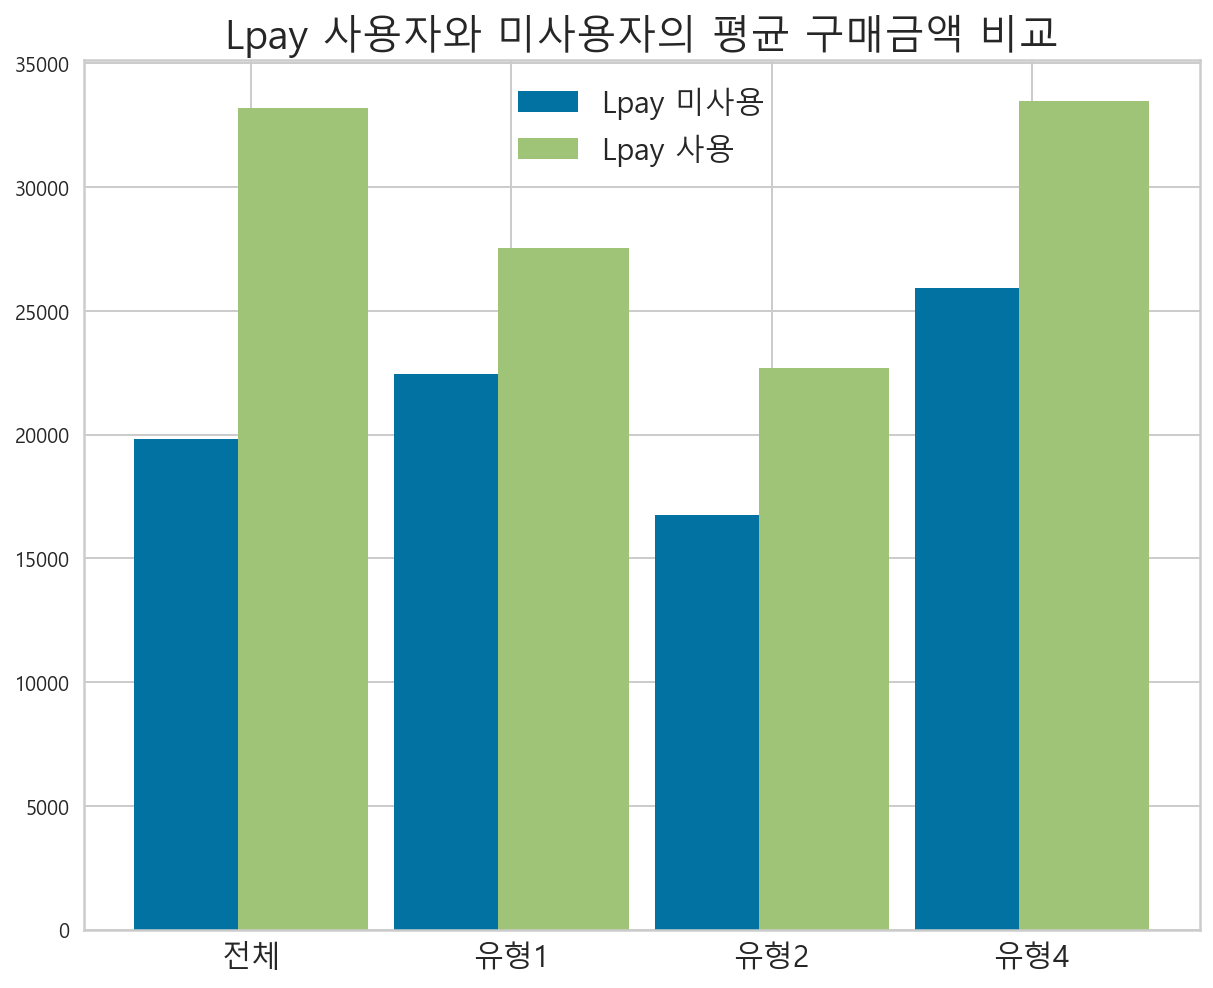

In [28]:
# 유형 3의 경우 Lpay를 사용하지 않는 고객의 평균 구매비용이 더 높음
x = np.arange(4)

plt.figure(figsize=(10, 8))
plt.bar(x-0.2, [lpay_x[0], lpay_x[1], lpay_x[2], lpay_x[4]], 0.5, label='Lpay 미사용')
plt.bar(x+0.2, [lpay_o[0], lpay_o[1], lpay_o[2], lpay_o[4]], 0.5, label='Lpay 사용')
plt.xticks(x, ['전체', '유형1', '유형2', '유형4'], fontsize = 15)
plt.legend(fontsize = 15)
plt.title('Lpay 사용자와 미사용자의 평균 구매금액 비교', fontsize=20)
plt.show()

    - 유형3을 제외한 나머지 유형들은 Lpay를 사용하는 고객의 평균 구매금액이 더 높음을 알 수 있다.

### 가장 많이 구매한 품목 확인

- 대, 중, 소분류 모두 확인해 보았으나 유형별 특징을 가장 잘 나타내는 중분류명으로 진행

- wordcloud로 확인

In [29]:
most_buy = df.groupby('고객번호')['중분류명'].apply(list).apply(lambda x:max(x, key = x.count)).reset_index()

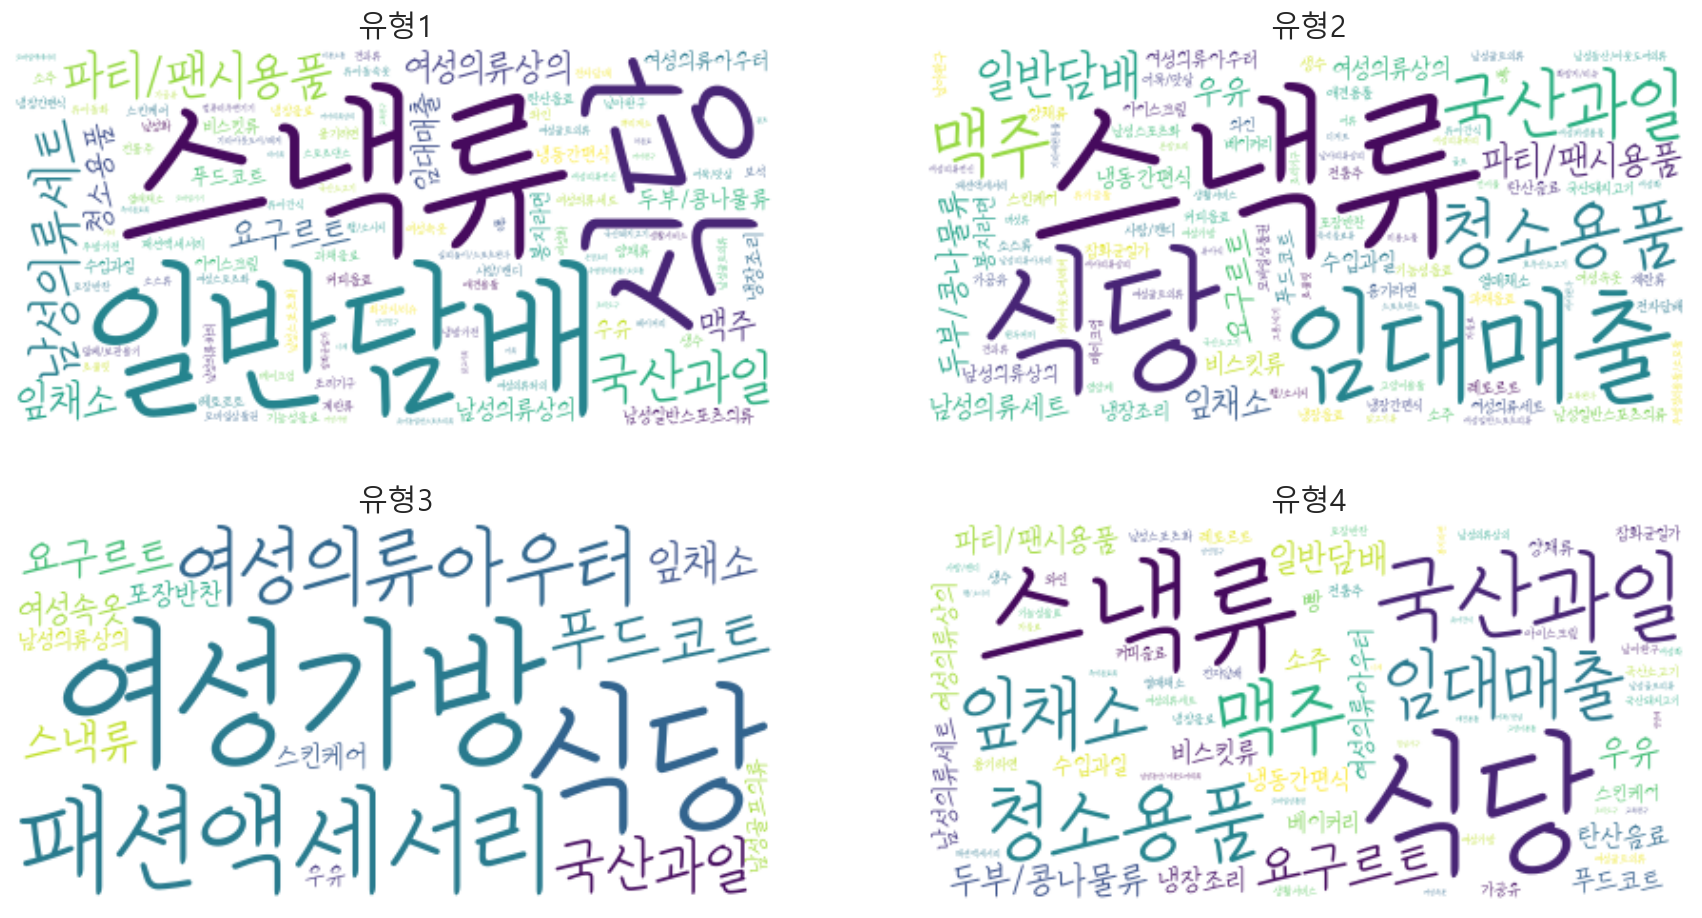

In [30]:
# 필요한 폰트를 폴더에 저장
fontpath = '../3. 우리 좀 롯데_데이터 및 모델 세이브 파일/DXBarunscriptM-KSCpc-EUC-H.ttf'

wordcloud_0 = WordCloud(
                      font_path = fontpath, 
                      background_color='white',
                      random_state = 20, 
                      max_words = 200).generate_from_frequencies(Counter(most_buy[most_buy['고객번호'].isin(customer_0)]['중분류명'].dropna()))
wordcloud_1 = WordCloud(
                      font_path = fontpath, 
                      background_color='white',
                      random_state = 20, 
                      max_words = 200).generate_from_frequencies(Counter(most_buy[most_buy['고객번호'].isin(customer_1)]['중분류명'].dropna()))
wordcloud_2 = WordCloud(
                      font_path = fontpath, 
                      background_color='white',
                      random_state = 20, 
                      max_words = 200).generate_from_frequencies(Counter(most_buy[most_buy['고객번호'].isin(customer_2)]['중분류명'].dropna()))
wordcloud_3 = WordCloud(
                      font_path = fontpath, 
                      background_color='white',
                      random_state = 20, 
                      max_words = 200).generate_from_frequencies(Counter(most_buy[most_buy['고객번호'].isin(customer_3)]['중분류명'].dropna()))



plt.figure(figsize = (15, 8))
# 유형1
plt.subplot(2, 2, 1)
plt.imshow(wordcloud_0, interpolation = "bilinear")
plt.axis("off")
plt.title('유형1', fontsize=15)
# 유형2
plt.subplot(2, 2, 2)
plt.imshow(wordcloud_1, interpolation = "bilinear")
plt.axis("off")
plt.title('유형2', fontsize=15)
# 유형3
plt.subplot(2, 2, 3)
plt.imshow(wordcloud_2, interpolation = "bilinear")
plt.axis("off")
plt.title('유형3', fontsize=15)
# 유형4
plt.subplot(2, 2, 4)
plt.imshow(wordcloud_3, interpolation = "bilinear")
plt.axis("off")
plt.title('유형4', fontsize=15)
plt.show()

#### 온라인, 오프라인 이용 여부를 파이차트를 통해 확인

In [31]:
ch = df.groupby('고객번호')['채널구분'].apply(list).reset_index()

In [32]:
# 온라인 오프라인 이용 여부를 세가지로 나누어 확인
def div_ch(x):
    if set(x) == {1}: # 오프라인만 이용하는 경우
        return '오프라인'
    elif set(x) == {2}: # 온라인만 이용
        return '온라인'
    else: # 둘다이용
        return '둘다이용'

# 이용채널과 이용 횟수를 구해줌
ch['이용채널'] = ch['채널구분'].apply(div_ch)
ch['이용횟수'] = ch['채널구분'].apply(lambda x:len(x))

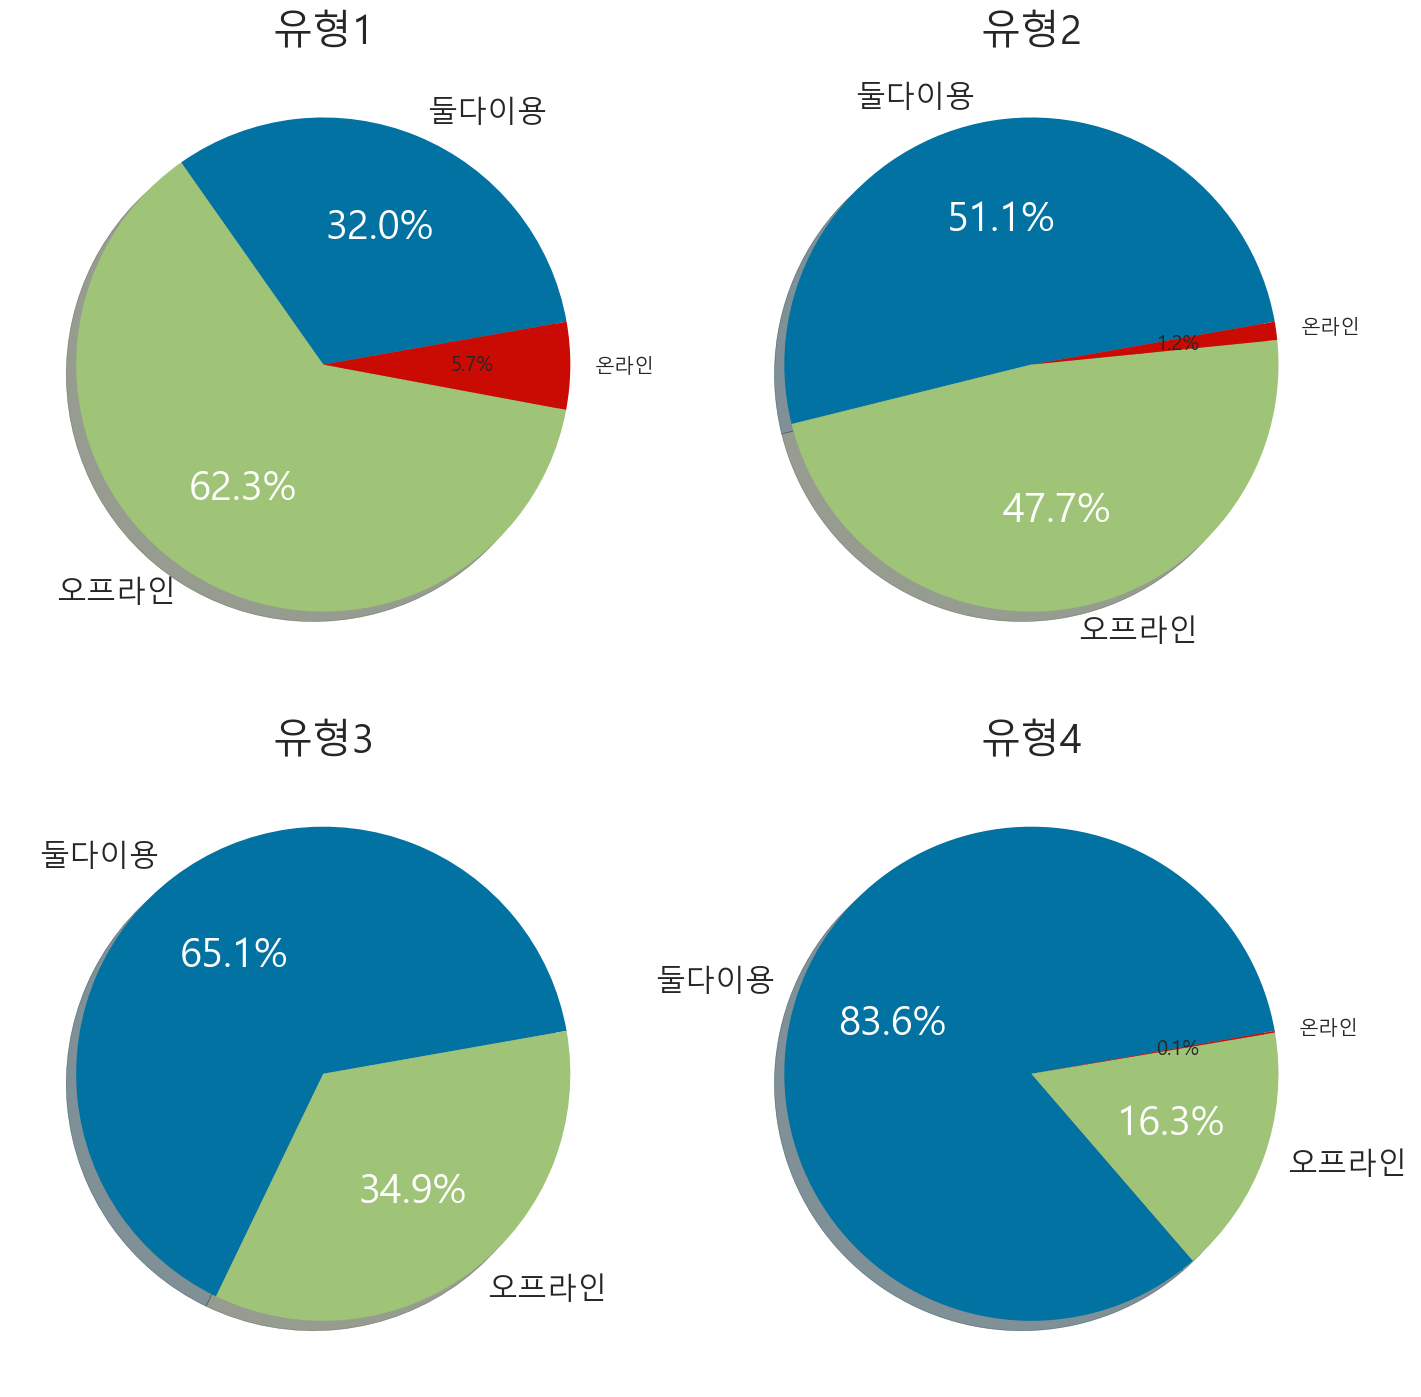

In [33]:
plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
patches_0, texts_0, autotexts_0 = plt.pie(
    ch[ch['고객번호'].isin(customer_0)].groupby('이용채널').count().reset_index()['고객번호'],
    labels = ch[ch['고객번호'].isin(customer_0)].groupby('이용채널').count().reset_index()['이용채널'],
    labeldistance=1.1,## label이 파이로부터 얼마나 떨어지는가, 1일경우 딱 붙어있음. 
    startangle=10,## 어디에서 시작할지, 정해줌  
    shadow=True, ##그림자 
    autopct='%1.1f%%', ## pi 위에 표시될 글자 형태, 또한 알아서 %로 변환해서 알려줌 
)
plt.title('유형1', size = 20)

plt.subplot(2, 2, 2)
patches_1, texts_1, autotexts_1 = plt.pie(
    ch[ch['고객번호'].isin(customer_1)].groupby('이용채널').count().reset_index()['고객번호'],
    labels = ch[ch['고객번호'].isin(customer_1)].groupby('이용채널').count().reset_index()['이용채널'],
    labeldistance=1.1,
    startangle=10,
    shadow=True,
    autopct='%1.1f%%', 
)
plt.title('유형2', size = 20)

plt.subplot(2, 2, 3)
patches_2, texts_2, autotexts_2 = plt.pie(
    ch[ch['고객번호'].isin(customer_2)].groupby('이용채널').count().reset_index()['고객번호'],
    labels = ch[ch['고객번호'].isin(customer_2)].groupby('이용채널').count().reset_index()['이용채널'],
    labeldistance=1.1,
    startangle=10,
    shadow=True,
    autopct='%1.1f%%', 
)
plt.title('유형3', size = 20)

plt.subplot(2, 2, 4)
patches_3, texts_3, autotexts_3 = plt.pie(
    ch[ch['고객번호'].isin(customer_3)].groupby('이용채널').count().reset_index()['고객번호'],
    labels = ch[ch['고객번호'].isin(customer_3)].groupby('이용채널').count().reset_index()['이용채널'],
    labeldistance=1.1,
    startangle=10,
    shadow=True,
    autopct='%1.1f%%', 
)
plt.title('유형4', size = 20)

for t1, t2, t3, t4 in zip(autotexts_0, autotexts_1, autotexts_2, autotexts_3):
    t1.set_color("white")
    t1.set_fontsize(20)
    t2.set_color("white")
    t2.set_fontsize(20)
    t3.set_color("white")
    t3.set_fontsize(20)
    t4.set_color("white")
    t4.set_fontsize(20)

for t1,t2,t3,t4 in zip(texts_0, texts_1, texts_2, texts_3):
    t1.set_fontsize(15)
    t2.set_fontsize(15)
    t3.set_fontsize(15)
    t4.set_fontsize(15)
    
plt.tight_layout()
plt.show()

#### 유형별 이탈 위험률 분포

#####  EDA를 위해 이탈 위험율 예측

- 최종 접속 경과일 (최종 구매 경과일)

In [34]:
imp = df.sort_values(by=['날짜'], ascending=[True]).groupby(['고객번호', '날짜'])[['채널구분']].count().reset_index().groupby('고객번호')['날짜'].agg([('구매일수', 'count')]).reset_index()
# 딱 하루만 구매한 고객들
oneday_buyer = list(imp[imp['구매일수']==1]['고객번호'])
# 고객별 구매 날짜
imp2 = df.groupby(['고객번호', '날짜'])[['채널구분']].count().drop('채널구분', axis=1).reset_index()
# 최근 구매일자별 최근 상위 2개를 구함
result = imp2.sort_values(by=['고객번호', '날짜']).groupby('고객번호')['날짜'].apply(set).reset_index()
result['최근상위2'] = result['날짜'].apply(lambda x:sorted(list(x))[-2:])
# 상위 두일자의 차이를 구한 후 빼줌
result['최종구매경과일'] = result['최근상위2'].apply(lambda x: abs(x[1] - x[0]) if len(x) == 2 else abs(pd.to_datetime('2021-12-31') - x[0]))
# int로 변환
result['최종구매경과일'] = result['최종구매경과일'].dt.days
# 결과 도출
result = result[['고객번호','최종구매경과일']];result.head(3)

,고객번호,최종구매경과일
0,M000034966,54
1,M000059535,303
2,M000136117,14


- 평균 구매일 주기

In [35]:
diff_final_buy = df.groupby('고객번호')['날짜'].diff().fillna('0').astype(str)
diff_final_buy = diff_final_buy.apply(lambda x: abs(int(x.split()[0])))
df['diff'] = diff_final_buy
f = df.groupby(['고객번호'])[['diff']].sum().reset_index()
result['구매간격합'] = f['diff']
result['구매일수'] = imp['구매일수']
result['구매접속간격'] = result['구매일수']-1

In [36]:
# 평균구매주기
mean_buy_cycle = [] 

for i in range(result.shape[0]):
    try:
        mean_buy_cycle.append(result['구매간격합'][i]/result['구매접속간격'][i])

    except ZeroDivisionError:
        mean_buy_cycle.append(1)
        continue

In [37]:
result['평균구매주기'] = mean_buy_cycle
# 딱 하루 구매한 사람들은 평균구매주기를 1로 대체
result['평균구매주기'].fillna(1, inplace=True)

##### 이탈 위험 비율
- [최종구매경과일] / [평균구매주기]

In [38]:
result['이탈위험비율'] = result['최종구매경과일']/result['평균구매주기']
churn = result[['고객번호', '이탈위험비율']]

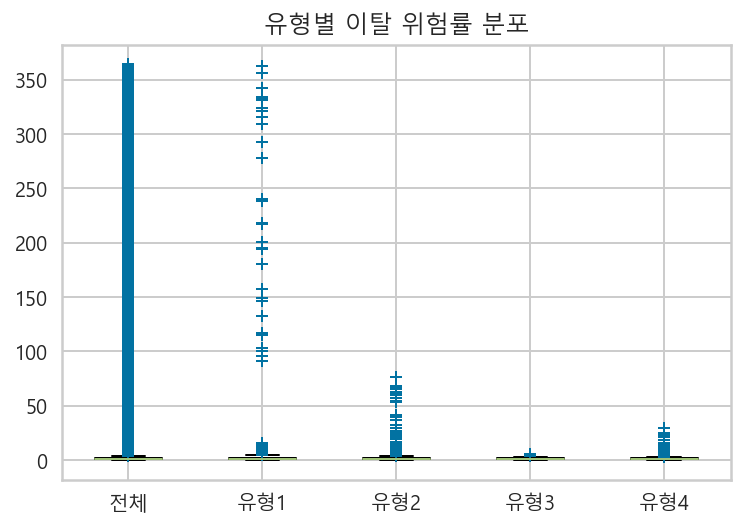

In [39]:
# 시각화로 확인
fig, ax = plt.subplots()
ax.boxplot([churn['이탈위험비율'],
            churn[churn['고객번호'].isin(customer_0)]['이탈위험비율'],
           churn[churn['고객번호'].isin(customer_1)]['이탈위험비율'],
           churn[churn['고객번호'].isin(customer_2)]['이탈위험비율'],
           churn[churn['고객번호'].isin(customer_3)]['이탈위험비율']], sym="b+")
plt.title('유형별 이탈 위험률 분포')
plt.xticks([1, 2, 3, 4, 5],['전체', '유형1', '유형2', '유형3', '유형4'])
plt.show()

#### 날짜별 활동량 추이 확인

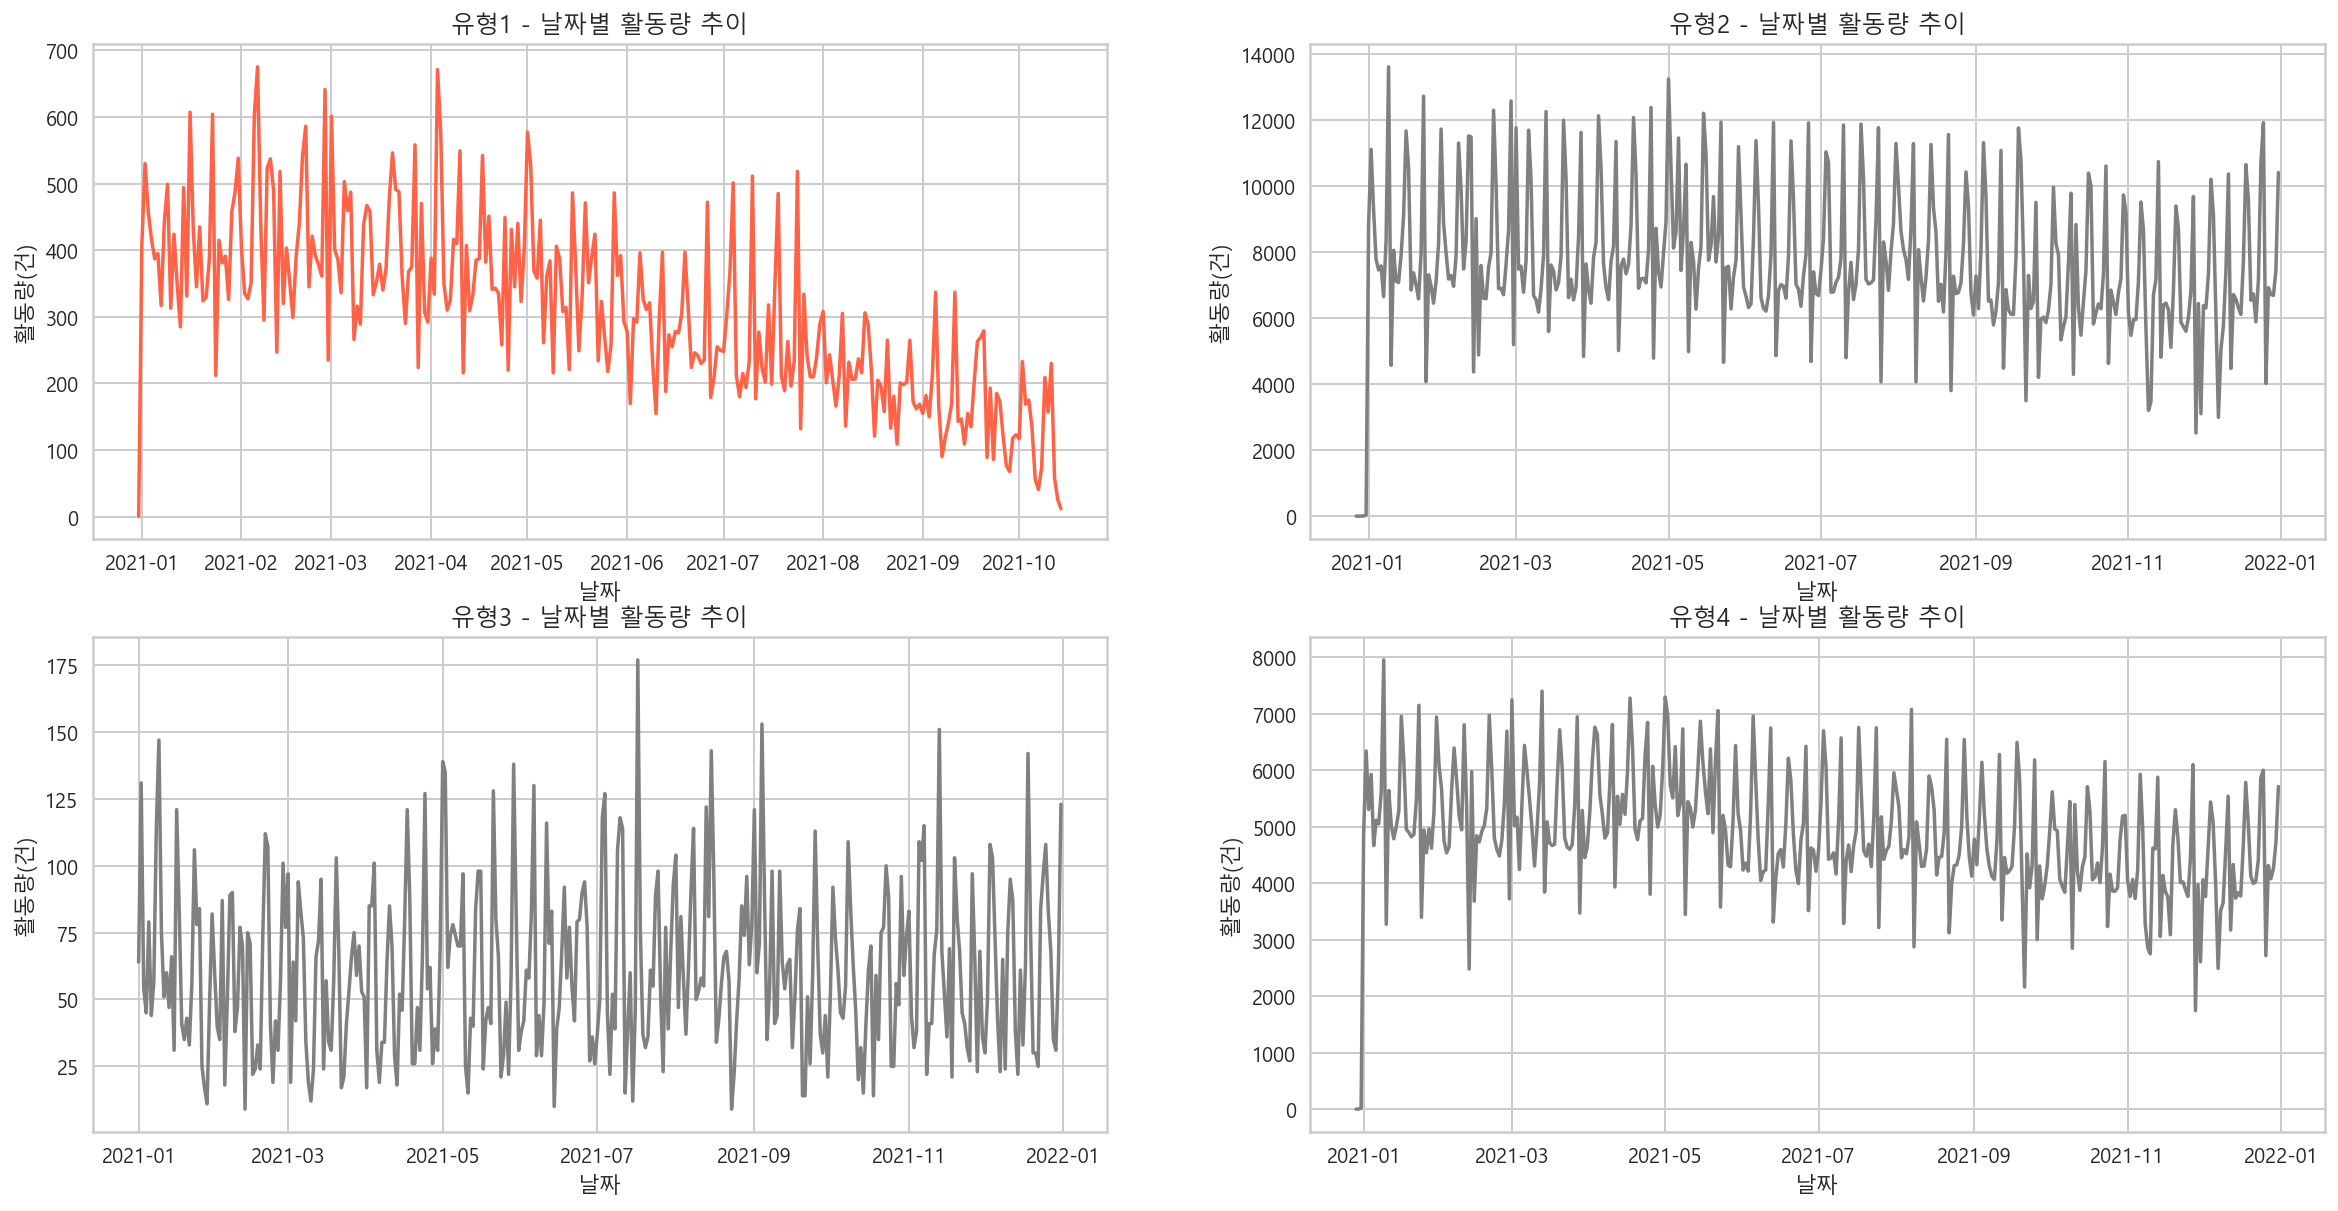

In [40]:
cust0_df = df[df['고객번호'].isin(customer_0)]
cust0_df = cust0_df.groupby('날짜').size().to_frame('count').reset_index()

cust1_df = df[df['고객번호'].isin(customer_1)]
cust1_df = cust1_df.groupby('날짜').size().to_frame('count').reset_index()

cust2_df = df[df['고객번호'].isin(customer_2)]
cust2_df = cust2_df.groupby('날짜').size().to_frame('count').reset_index()

cust3_df = df[df['고객번호'].isin(customer_3)]
cust3_df = cust3_df.groupby('날짜').size().to_frame('count').reset_index()


plt.figure(figsize=(20,10))
plt.subplot(2, 2, 1)
sns.lineplot(data=cust0_df, x='날짜', y='count', color='tomato')
plt.title('유형1 - 날짜별 활동량 추이')
plt.xlabel('날짜'); plt.ylabel('활동량(건)')

plt.subplot(2, 2, 2)
sns.lineplot(data=cust1_df, x='날짜', y='count', color='gray')
plt.title('유형2 - 날짜별 활동량 추이')
plt.xlabel('날짜'); plt.ylabel('활동량(건)')

plt.subplot(2, 2, 3)
sns.lineplot(data=cust2_df, x='날짜', y='count', color='gray')
plt.title('유형3 - 날짜별 활동량 추이')
plt.xlabel('날짜'); plt.ylabel('활동량(건)')

plt.subplot(2, 2, 4)
sns.lineplot(data=cust3_df, x='날짜', y='count', color='gray')
plt.title('유형4 - 날짜별 활동량 추이')
plt.xlabel('날짜'); plt.ylabel('활동량(건)')

plt.show()

    - 이탈 위험 비율과 비슷하게 유형1의 경우 시간이 지날수록 활동량이 줄어드는 모습을 보임

### 외부 데이터

- 코로나 데이터를 불러와서 확인해봄

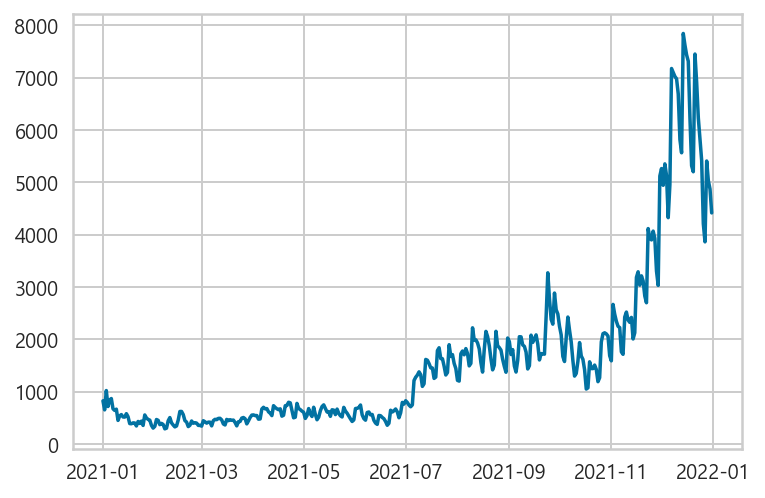

In [41]:
df_covid = pd.read_csv('../3. 우리 좀 롯데_데이터 및 모델 세이브 파일/[한국] 대한민국의 코로나19 총 누적 확진자와 사망자 _ 일간 (2022년 8월 9일).csv')
df_covid = df_covid[df_covid['일자'].apply(lambda x:x[0:4]) == '2021'].reset_index(drop=True)

df_covid['일자'] = pd.to_datetime(df_covid['일자'])

plt.plot(df_covid['일자'], df_covid['신규확진(명)'])
plt.show()

- 유형1의 이용량이 적어지는 이유와 코로나 확진자수의 증가를 함께 확인 해봄

In [42]:
# 유형1의 이용량과 코로나 신규확진자 데이터를 합쳐줌
cust0_df.columns = ['일자', 'count']
cust0_data = pd.merge(cust0_df, df_covid[['일자', '신규확진(명)']], how='left', on='일자').dropna().reset_index(drop=True)

In [43]:
cust0_data.iloc[:,1:].corr(method='pearson')

,count,신규확진(명)
count,1.000000,-0.677855
신규확진(명),-0.677855,1.000000


    - 상관계수가 -0.67로 양의 음의 상관계수를 띔

    - 신규확진자

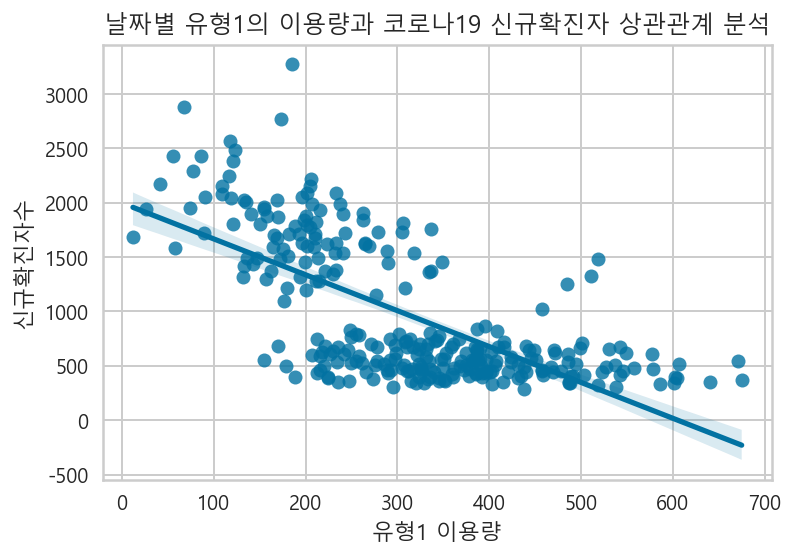

In [44]:
# 그래프로 확인
sns.regplot(x='count', y='신규확진(명)', data=cust0_data)
plt.title('날짜별 유형1의 이용량과 코로나19 신규확진자 상관관계 분석')
plt.xlabel('유형1 이용량')
plt.ylabel('신규확진자수')
plt.show()

    - 다른 유형과 코로나의 상관관계 분석

In [45]:
# 유형2의 이용량과 코로나 신규확진자 데이터를 합쳐줌
cust1_df.columns = ['일자', 'count']
cust1_data = pd.merge(cust1_df, df_covid[['일자', '신규확진(명)']], how='left', on='일자').dropna().reset_index(drop=True)
cust1_data.iloc[:,1:].corr(method='pearson')

,count,신규확진(명)
count,1.000000,-0.201292
신규확진(명),-0.201292,1.000000


In [46]:
# 유형3의 이용량과 코로나 신규확진자 데이터를 합쳐줌
cust2_df.columns = ['일자', 'count']
cust2_data = pd.merge(cust2_df, df_covid[['일자', '신규확진(명)']], how='left', on='일자').dropna().reset_index(drop=True)
cust2_data.iloc[:,1:].corr(method='pearson')

,count,신규확진(명)
count,1.000000,-0.006453
신규확진(명),-0.006453,1.000000


In [47]:
# 유형4의 이용량과 코로나 신규확진자 데이터를 합쳐줌
cust3_df.columns = ['일자', 'count']
cust3_data = pd.merge(cust3_df, df_covid[['일자', '신규확진(명)']], how='left', on='일자').dropna().reset_index(drop=True)
cust3_data.iloc[:,1:].corr(method='pearson')

,count,신규확진(명)
count,1.000000,-0.338661
신규확진(명),-0.338661,1.000000


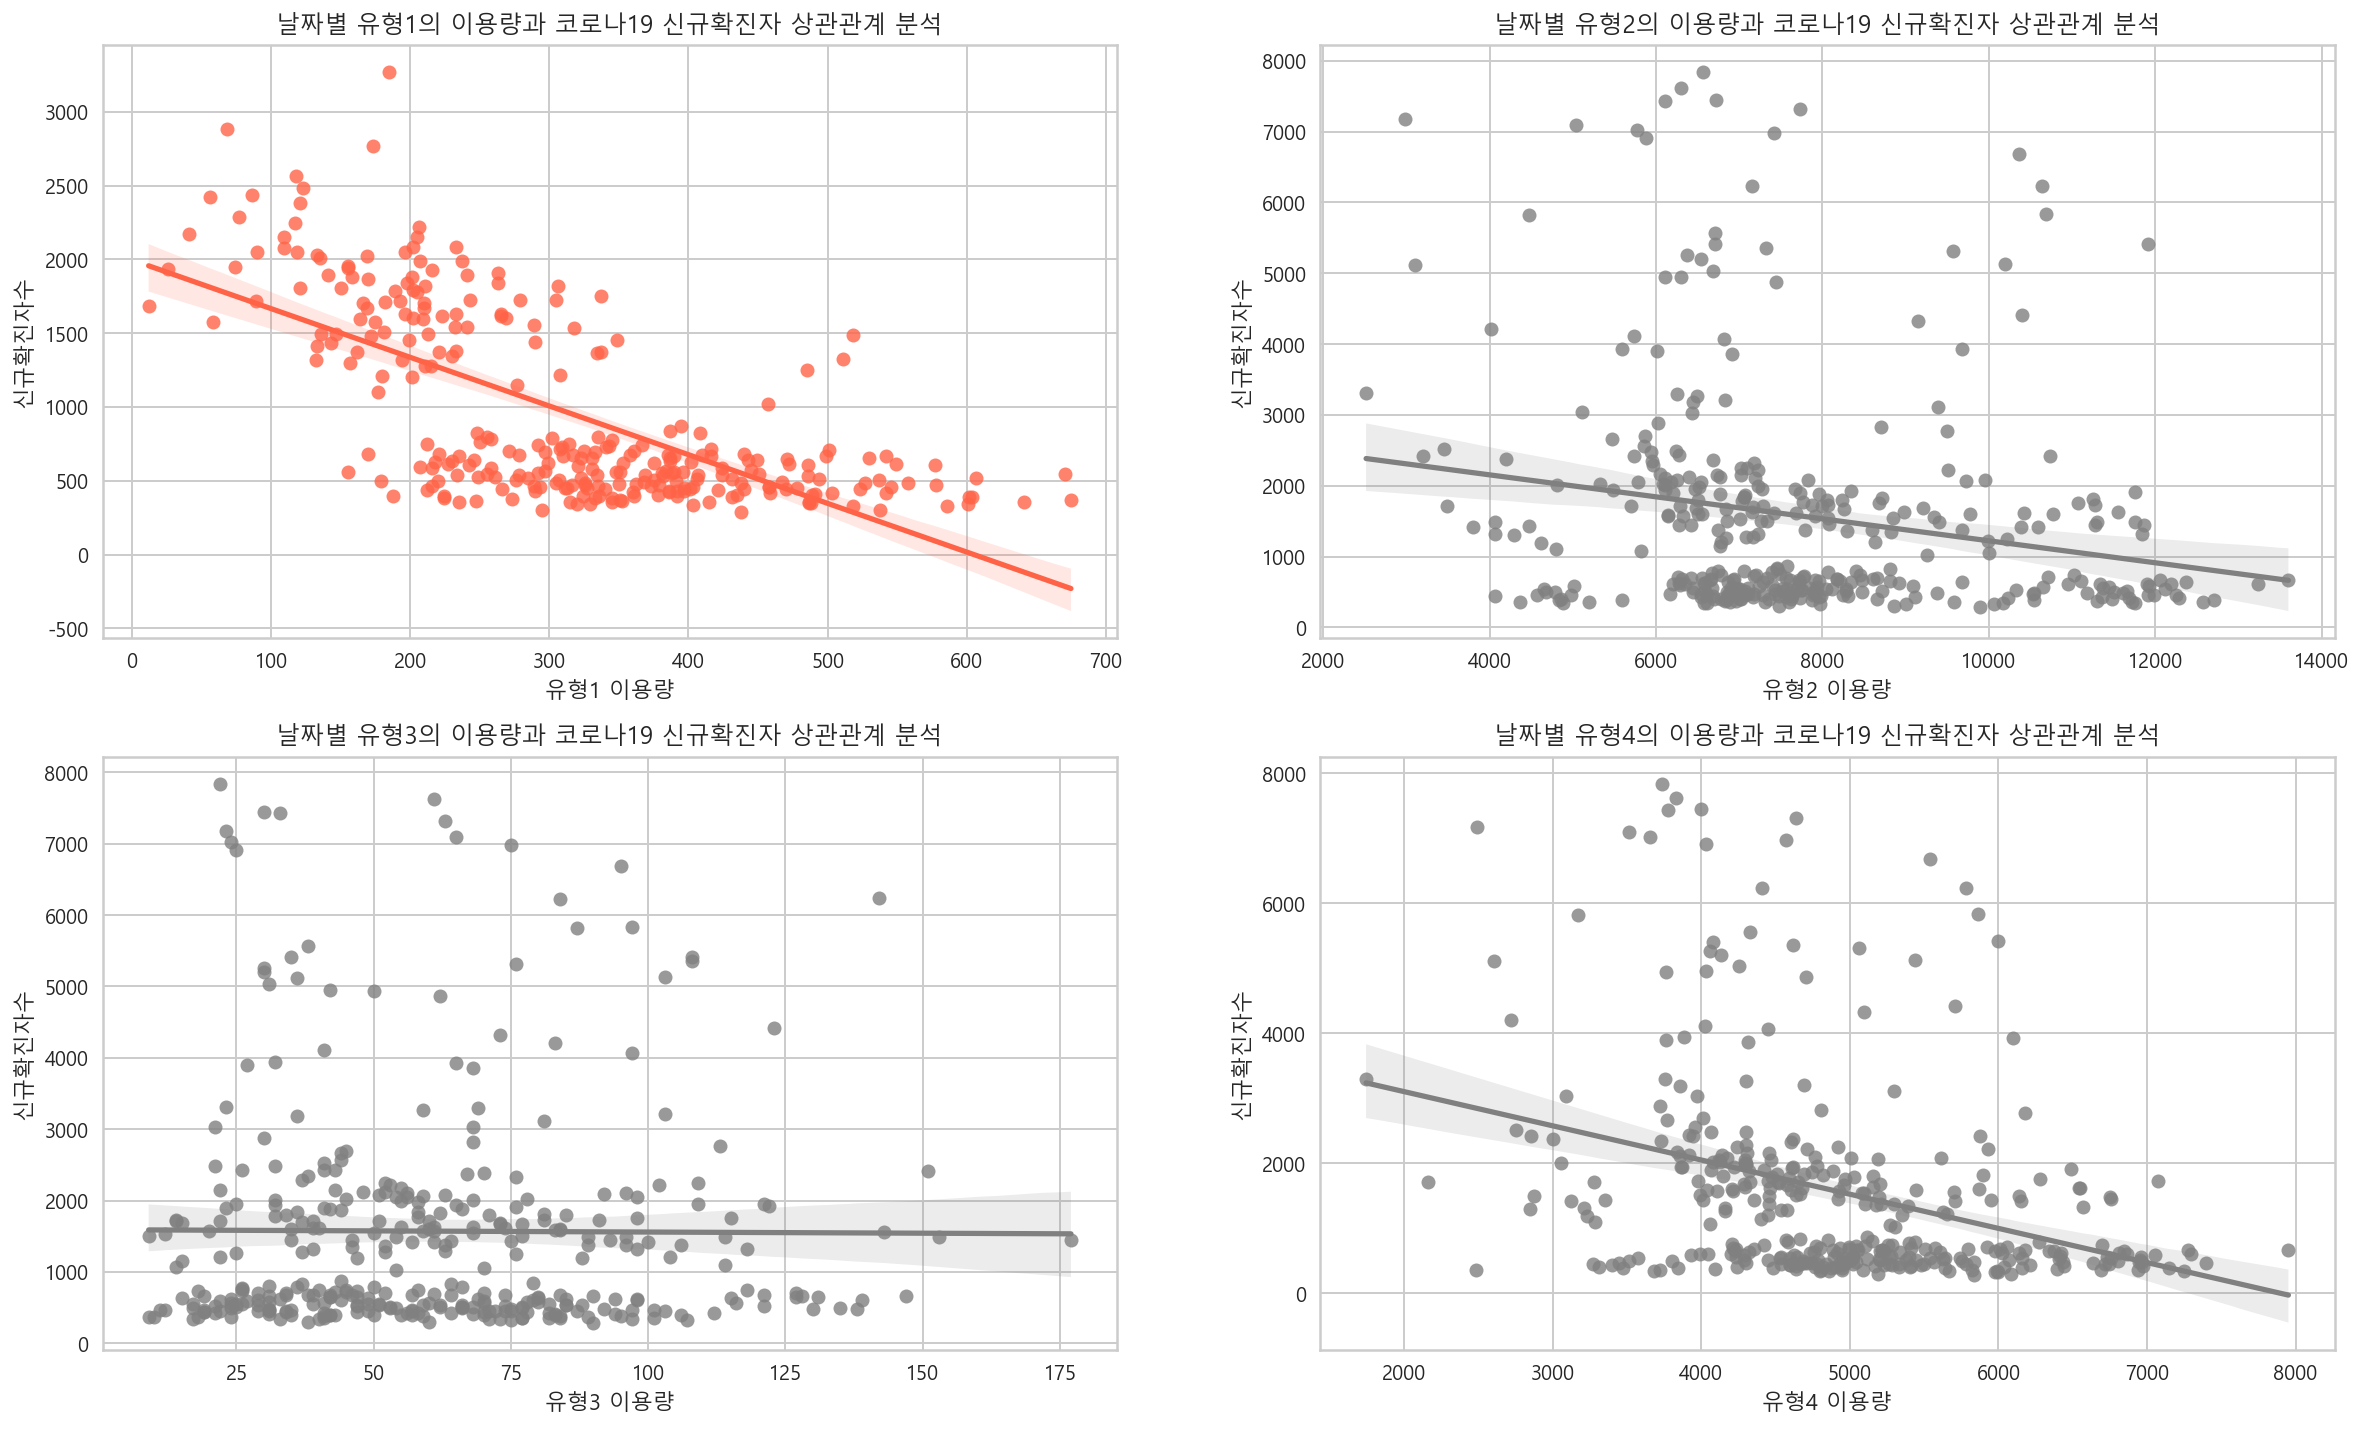

In [48]:
plt.figure(figsize=(20,12))
plt.subplot(2, 2, 1)
sns.regplot(x='count', y='신규확진(명)', data=cust0_data, color='tomato')
plt.title('날짜별 유형1의 이용량과 코로나19 신규확진자 상관관계 분석')
plt.xlabel('유형1 이용량'); plt.ylabel('신규확진자수')

plt.subplot(2, 2, 2)
sns.regplot(x='count', y='신규확진(명)', data=cust1_data, color='gray')
plt.title('날짜별 유형2의 이용량과 코로나19 신규확진자 상관관계 분석')
plt.xlabel('유형2 이용량'); plt.ylabel('신규확진자수')

plt.subplot(2, 2, 3)
sns.regplot(x='count', y='신규확진(명)', data=cust2_data, color='gray')
plt.title('날짜별 유형3의 이용량과 코로나19 신규확진자 상관관계 분석')
plt.xlabel('유형3 이용량'); plt.ylabel('신규확진자수')

plt.subplot(2, 2, 4)
sns.regplot(x='count', y='신규확진(명)', data=cust3_data, color='gray')
plt.title('날짜별 유형4의 이용량과 코로나19 신규확진자 상관관계 분석')
plt.xlabel('유형4 이용량'); plt.ylabel('신규확진자수')

plt.show()

    - 타 유형은 코로나와 큰 관련이 없음을 보임

#### 유형별 거래대분류 품목수

In [49]:
user = demo[demo['고객번호'].isin(trans['고객번호'])].reset_index(drop=True)
user['거래품목대분류수'] = df.groupby('고객번호')['대분류명'].apply(set).reset_index()['대분류명'].apply(lambda x:len(x))

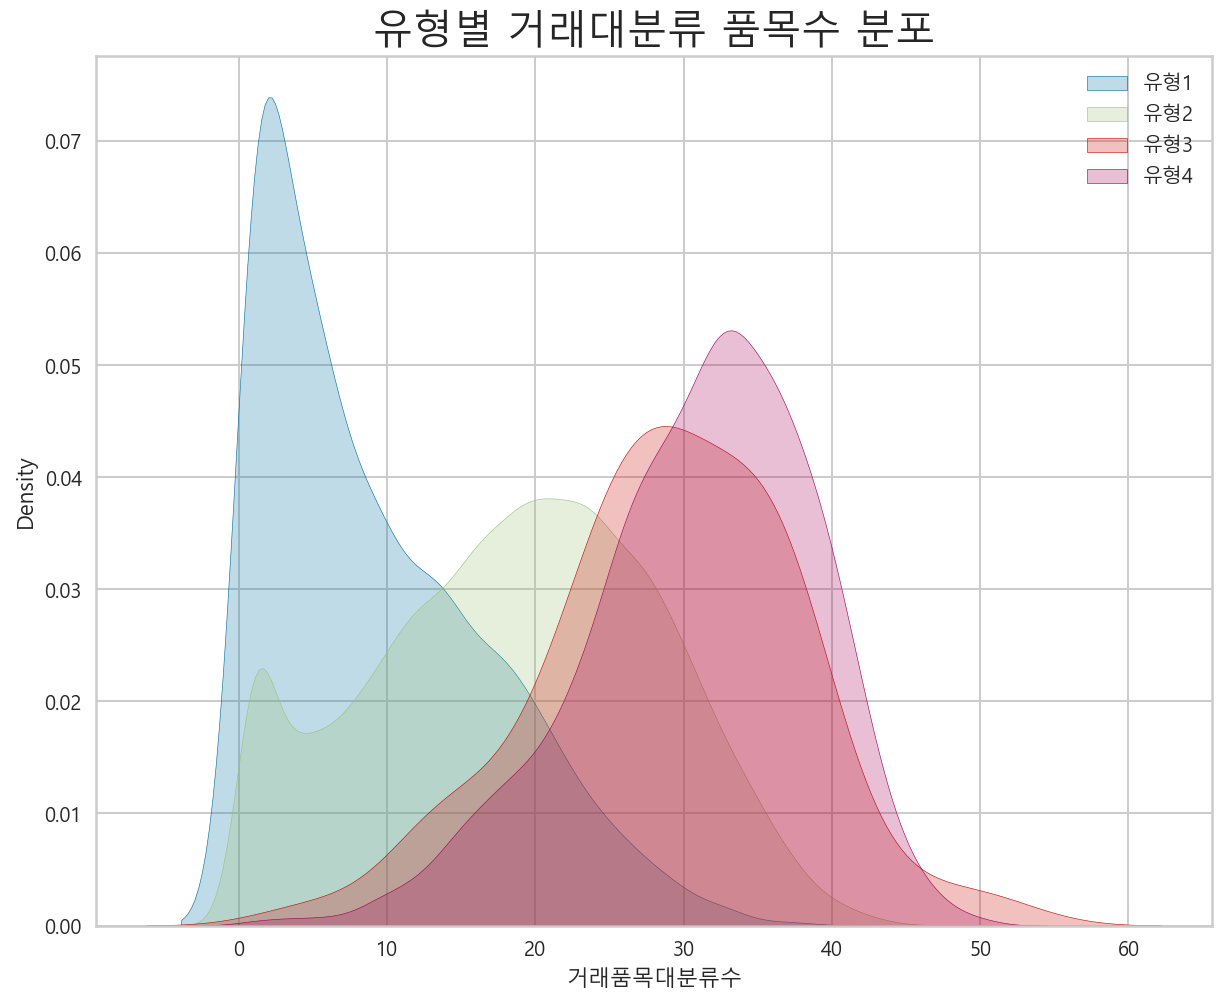

In [50]:
fig = plt.figure(figsize = (10,8))
sns.kdeplot(user[user['고객번호'].isin(customer_0)]['거래품목대분류수'], label = '유형1',shade = True)
sns.kdeplot(user[user['고객번호'].isin(customer_1)]['거래품목대분류수'], label = '유형2',shade = True)
sns.kdeplot(user[user['고객번호'].isin(customer_2)]['거래품목대분류수'], label = '유형3',shade = True)
sns.kdeplot(user[user['고객번호'].isin(customer_3)]['거래품목대분류수'], label = '유형4',shade = True)
plt.title('유형별 거래대분류 품목수 분포', fontsize=20)
plt.legend()
plt.show()

#### 유형별 엘페이 사용자의 수를 확인해봄

In [51]:
# 엘페이 사용 여부를 확인해봄
lpay_user = df[df['타입'] == 'Lpay']['고객번호'].unique()
user['Lpay이용여부'] = user['고객번호'].apply(lambda x:'Lpay사용' if x in lpay_user else 'Lpay미사용')

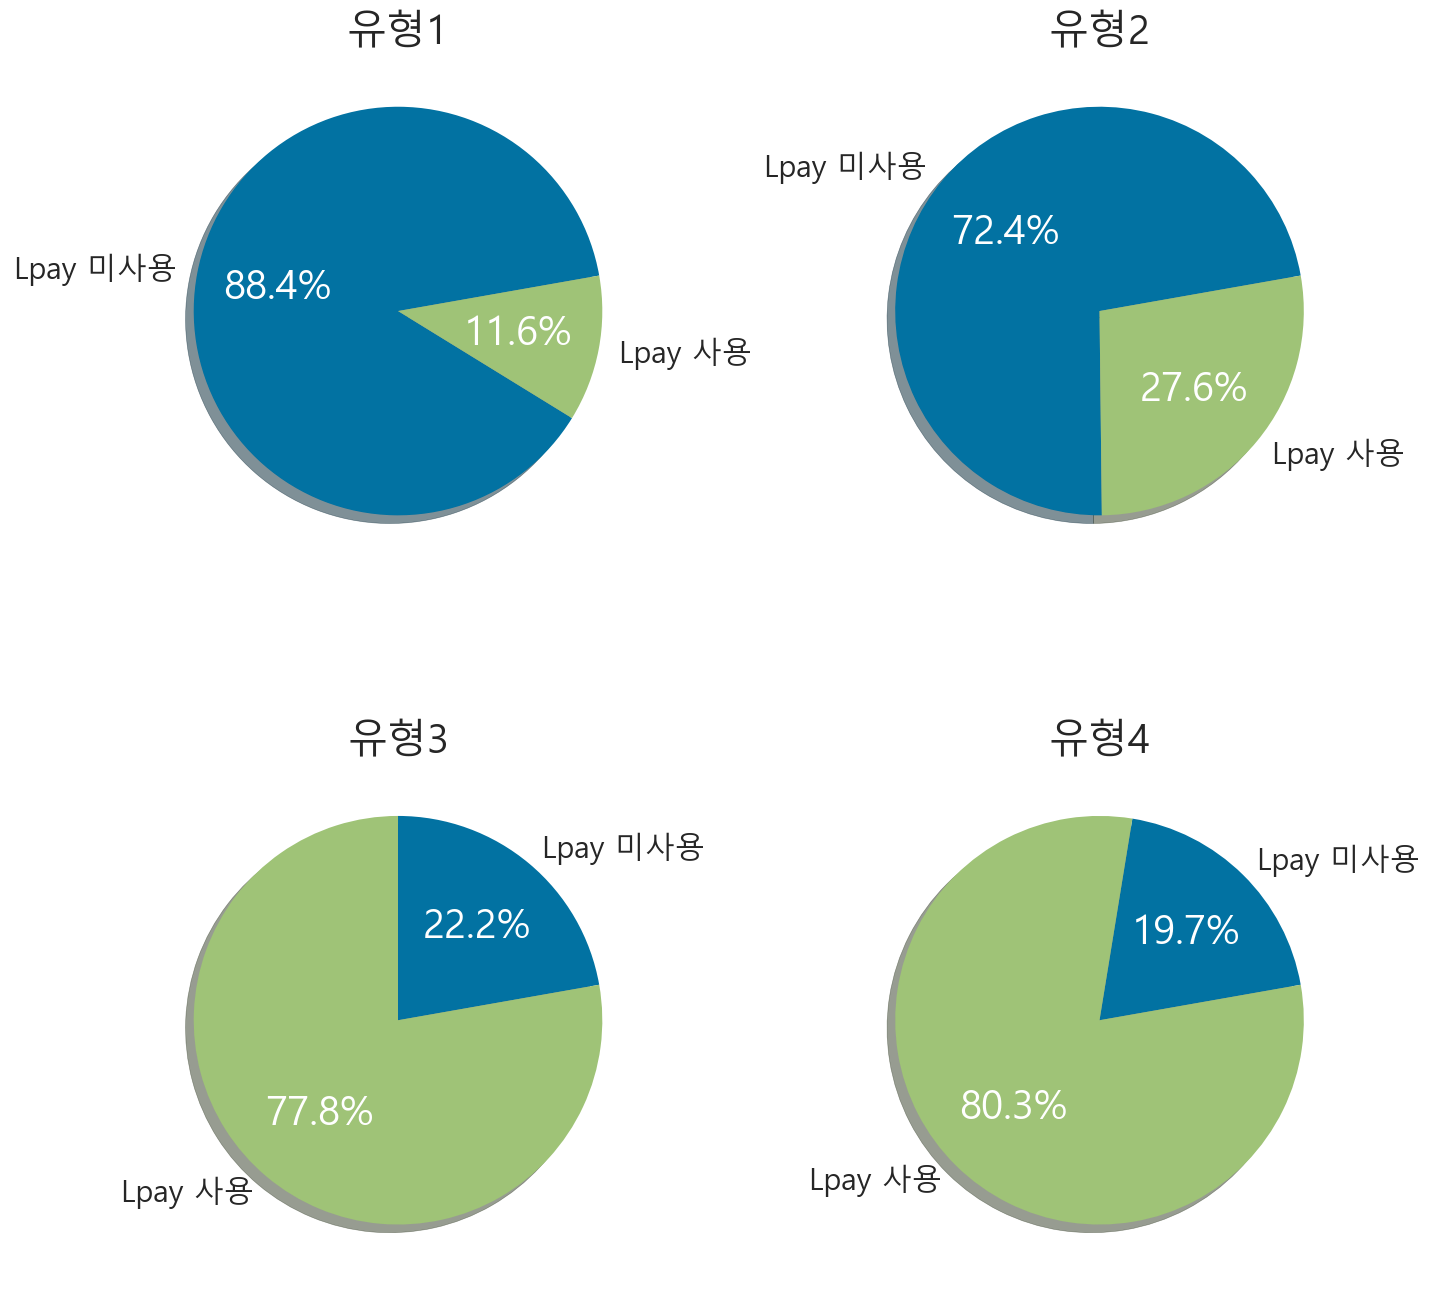

In [52]:
plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
patches_0, texts_0, autotexts_0 = plt.pie(
    user[user['고객번호'].isin(customer_0)].groupby('Lpay이용여부').count().reset_index()['고객번호'],
    labels = ['Lpay 미사용', 'Lpay 사용'],
    labeldistance=1.1,## label이 파이로부터 얼마나 떨어지는가, 1일경우 딱 붙어있음. 
    startangle=10,## 어디에서 시작할지, 정해줌  
    shadow=True, ##그림자 
    autopct='%1.1f%%', ## pi 위에 표시될 글자 형태, 또한 알아서 %로 변환해서 알려줌 
)
plt.title('유형1', size = 20)

plt.subplot(2, 2, 2)
patches_1, texts_1, autotexts_1 = plt.pie(
    user[user['고객번호'].isin(customer_1)].groupby('Lpay이용여부').count().reset_index()['고객번호'],
    labels = ['Lpay 미사용', 'Lpay 사용'],
    labeldistance=1.1,
    startangle=10,
    shadow=True,
    autopct='%1.1f%%', 
)
plt.title('유형2', size = 20)

plt.subplot(2, 2, 3)
patches_2, texts_2, autotexts_2 = plt.pie(
    user[user['고객번호'].isin(customer_2)].groupby('Lpay이용여부').count().reset_index()['고객번호'],
    labels = ['Lpay 미사용', 'Lpay 사용'],
    labeldistance=1.1,
    startangle=10,
    shadow=True,
    autopct='%1.1f%%', 
)
plt.title('유형3', size = 20)

plt.subplot(2, 2, 4)
patches_3, texts_3, autotexts_3 = plt.pie(
    user[user['고객번호'].isin(customer_3)].groupby('Lpay이용여부').count().reset_index()['고객번호'],
    labels = ['Lpay 미사용', 'Lpay 사용'],
    labeldistance=1.1,
    startangle=10,
    shadow=True,
    autopct='%1.1f%%', 
)
plt.title('유형4', size = 20)

for t1, t2, t3, t4 in zip(autotexts_0, autotexts_1, autotexts_2, autotexts_3):
    t1.set_color("white")
    t1.set_fontsize(20)
    t2.set_color("white")
    t2.set_fontsize(20)
    t3.set_color("white")
    t3.set_fontsize(20)
    t4.set_color("white")
    t4.set_fontsize(20)

for t1,t2,t3,t4 in zip(texts_0, texts_1, texts_2, texts_3):
    t1.set_fontsize(15)
    t2.set_fontsize(15)
    t3.set_fontsize(15)
    t4.set_fontsize(15)
    
plt.tight_layout()
plt.show()

## END